In [1]:
import importlib

import dataset, metrics, plotting, config
from models import reg_cgan_model
import numpy as np
import random

importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(reg_cgan_model)

Using TensorFlow backend.
/Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

<module 'models.reg_cgan_model' from '/Users/zhongsheng/Documents/GitWorkspace/RegCGAN/models/reg_cgan_model.py'>

In [12]:
import os

dataset_config = config.DatasetConfig(scenario="magical_sinus", n_instance=250)

assert(dataset_config.scenario == "magical_sinus"
       or dataset_config.scenario == "hdpe"
      )
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ") 
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/magical_sinus already exists replacing files in this notebook


In [13]:
exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=0.005, lr_disc=0.005, optim_gen="Adam",
                             optim_disc="Adam", z_input_size=5),
    training=config.TrainingConfig(n_epochs=10000, batch_size=100, n_sampling=200),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [14]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

from tensorflow import set_random_seed
set_random_seed(exp_config.model.random_seed)

In [15]:
X_train, y_train, X_valid, y_valid = dataset.get_dataset(exp_config.dataset.n_instance,
                                                                         exp_config.dataset.scenario)

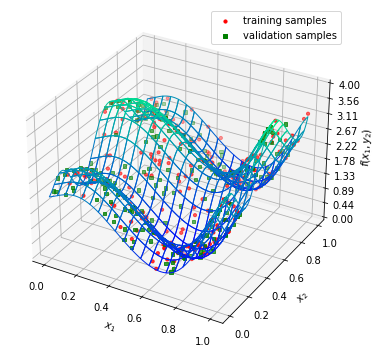

In [15]:
%matplotlib inline 
plotting.plot_dataset(X_train, X_valid, y_train, y_valid, exp_config, fig_dir)

## Finding sparse regions using Local Outlier Factor (LOF)

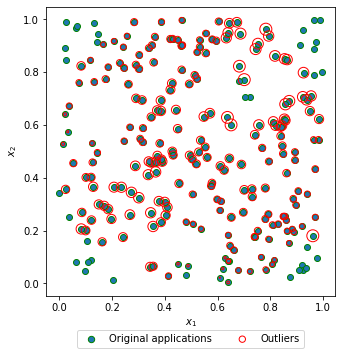

In [16]:
from sklearn.neighbors import LocalOutlierFactor


X = X_train
clf = LocalOutlierFactor(n_neighbors=240)
clf.fit(X)
X_scores = clf.negative_outlier_factor_
mean_scores = np.mean(X_scores)
mask = X_scores > mean_scores

X_outliers = X[mask]
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

if len(X_outliers):

    # plot the original data points where outliers are marked by cycles.
    # The more larger the circle, the more isolated the data points away from 
    # its neighbors.
    plotting.plot_sparse_regions(X, X_outliers, radius[mask], fig_dir)

## CVT sampling and discrepancy evaluating

In [17]:

from idaes.surrogate.pysmo import sampling as sp
from diversipy import unanchored_L2_discrepancy

assert len(X_outliers) !=0, "No sparse regions in the input space has been found."

min_n_sampling, max_n_sampling, interval = 60, 260, 20

minimum, maximum = np.amin(X_outliers, axis=0).tolist(), np.amax(X_outliers, axis=0).tolist()
bounds = [minimum, maximum]

X_discrepancy = unanchored_L2_discrepancy(X_outliers)
X_CVT_discrepancy_list, X_full_discrepancy_list, CVT_dict = [], [], {}
i = 0
for n_sampling in range(min_n_sampling, max_n_sampling, interval):
    space_init = sp.CVTSampling(bounds, sampling_type="creation", number_of_samples=n_sampling)
    X_CVT = space_init.sample_points()
    CVT_dict[f"num_sampling_{n_sampling}"] = X_CVT
    X_CVT_discrepancy = unanchored_L2_discrepancy(X_CVT)
    X_CVT_discrepancy_list.append(X_CVT_discrepancy)

    X_full = np.r_[X, X_CVT]
    X_full_discrepancy = unanchored_L2_discrepancy(X_full)
    X_full_discrepancy_list.append(X_full_discrepancy)
    print(f"Discrepancy values: {X_discrepancy:.4f} for original data; "
          f"{X_CVT_discrepancy:.4f} for {n_sampling} CVT samples; "
          f"{X_full_discrepancy:4f} for full data.")

best_n_sampling = np.arange(min_n_sampling, max_n_sampling, interval)[np.argmin(np.array(X_full_discrepancy_list))]
best_CVT = CVT_dict[f"num_sampling_{best_n_sampling}"]
print(f"The  optimal value for n_sampling in CVT sampling is {best_n_sampling}")

ModuleNotFoundError: No module named 'idaes'

In [ ]:
X_discrepancy = unanchored_L2_discrepancy(X_outliers)
plotting.plot_cvt_discrepancy(min_n_sampling, max_n_sampling, interval, X_full_discrepancy_list, fig_dir,
                              title=f"Discrepancy baseline = {X_discrepancy:2.5f}")

In [ ]:
from scipy.spatial import Voronoi
from scipy.spatial import voronoi_plot_2d

sampling_key = f"num_sampling_{best_n_sampling}"
X_CVT = CVT_dict[sampling_key]

# plot CVT samples
plotting.plot_voronoi_cvt(X_outliers, X_CVT, Voronoi, voronoi_plot_2d, fig_dir)

# save CVT samples to .npy file
from os.path import basename
np.save(f"{fig_dir}/{basename(fig_dir)}_CVT_samples.npy", X_CVT)

## Gaussian Process 

In [16]:
import GPy

noise = 4.3
length = 16

run_hyperopt_search = True

kernel = GPy.kern.RBF(input_dim=2, variance=noise, lengthscale=length)
gpr = GPy.models.GPRegression(X_train, y_train, kernel)
if run_hyperopt_search:
    gpr.optimize(messages=True)
ypred_gp_valid, cov_valid = gpr.predict(X_valid)

 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


## Construct RegCGAN model

In [17]:
regcgan = reg_cgan_model.RegCGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = regcgan.train(X_train, y_train,
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size,
                                                                              verbose=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_input_x (InputLayer)  (None, 2)            0                                            
__________________________________________________________________________________________________
Generator_input_z (InputLayer)  (None, 5)            0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 20)           60          Generator_input_x[0][0]          
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 20)           120         Generator_input_z[0][0]          
__________________________________________________________________________________________________
concatenat

 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Epoch: 0 / dLoss: 1.4436160326004028 / gLoss: 0.48078805208206177
Epoch: 1 / dLoss: 2.1910817623138428 / gLoss: 0.29785412549972534
Epoch: 2 / dLoss: 1.6875373125076294 / gLoss: 0.6961326599121094
Epoch: 3 / dLoss: 1.1967504024505615 / gLoss: 1.7353976964950562
Epoch: 4 / dLoss: 0.9341161847114563 / gLoss: 2.04713773727417
Epoch: 5 / dLoss: 0.8311501145362854 / gLoss: 1.3713531494140625
Epoch: 6 / dLoss: 1.460886836051941 / gLoss: 0.7432989478111267
Epoch: 7 / dLoss: 2.5636708736419678 / gLoss: 0.3012450337409973
Epoch: 8 / dLoss: 1.8483086824417114 / gLoss: 0.7888001203536987
Epoch: 9 / dLoss: 1.2595093250274658 / gLoss: 1.0279641151428223
Epoch: 10 / dLoss: 1.1352547407150269 / gLoss: 1.0051037073135376
Epoch: 11 / dLoss: 1.3627156019210815 / gLoss: 0.8946316242218018
Epoch: 12 / dLoss: 1.9125909805297852 / gLoss: 0.6746921539306641
Epoch: 13 / dLoss: 1.9776980876922607 / gLoss: 0.5440235733985901
Epoch: 14 / dLoss: 1.6791560649871826 / gLoss: 0.6722712516784668
Epoch: 15 / dLoss: 1.

Epoch: 127 / dLoss: 1.142351746559143 / gLoss: 0.9210643172264099
Epoch: 128 / dLoss: 1.1513221263885498 / gLoss: 0.8615248203277588
Epoch: 129 / dLoss: 1.282874345779419 / gLoss: 0.6286124587059021
Epoch: 130 / dLoss: 1.3607665300369263 / gLoss: 0.9020942449569702
Epoch: 131 / dLoss: 1.3754026889801025 / gLoss: 0.9291861653327942
Epoch: 132 / dLoss: 1.5657780170440674 / gLoss: 0.7896966338157654
Epoch: 133 / dLoss: 1.45401132106781 / gLoss: 0.7441092133522034
Epoch: 134 / dLoss: 1.477132797241211 / gLoss: 0.7712417840957642
Epoch: 135 / dLoss: 1.5008180141448975 / gLoss: 0.7813540697097778
Epoch: 136 / dLoss: 1.4944301843643188 / gLoss: 0.7728236317634583
Epoch: 137 / dLoss: 1.4626240730285645 / gLoss: 0.7786622643470764
Epoch: 138 / dLoss: 1.4428343772888184 / gLoss: 0.7733830213546753
Epoch: 139 / dLoss: 1.4205904006958008 / gLoss: 0.7606197595596313
Epoch: 140 / dLoss: 1.4014469385147095 / gLoss: 0.7451986074447632
Epoch: 141 / dLoss: 1.3804794549942017 / gLoss: 0.7450718879699707


Epoch: 251 / dLoss: 1.3832743167877197 / gLoss: 0.7691473364830017
Epoch: 252 / dLoss: 1.3779393434524536 / gLoss: 0.774655818939209
Epoch: 253 / dLoss: 1.3584537506103516 / gLoss: 0.8661449551582336
Epoch: 254 / dLoss: 1.3696340322494507 / gLoss: 0.9434432983398438
Epoch: 255 / dLoss: 1.364335536956787 / gLoss: 0.7648448348045349
Epoch: 256 / dLoss: 1.3685193061828613 / gLoss: 0.7579798698425293
Epoch: 257 / dLoss: 1.405851125717163 / gLoss: 0.6375924944877625
Epoch: 258 / dLoss: 1.40260648727417 / gLoss: 0.6446853876113892
Epoch: 259 / dLoss: 1.3980345726013184 / gLoss: 0.6683496236801147
Epoch: 260 / dLoss: 1.3756499290466309 / gLoss: 0.7142745852470398
Epoch: 261 / dLoss: 1.3865094184875488 / gLoss: 0.7407820224761963
Epoch: 262 / dLoss: 1.3944530487060547 / gLoss: 0.7563766241073608
Epoch: 263 / dLoss: 1.4060249328613281 / gLoss: 0.754758894443512
Epoch: 264 / dLoss: 1.4050045013427734 / gLoss: 0.7487441897392273
Epoch: 265 / dLoss: 1.408172845840454 / gLoss: 0.7409583926200867
Ep

Epoch: 377 / dLoss: 1.394413948059082 / gLoss: 0.6929342746734619
Epoch: 378 / dLoss: 1.3923144340515137 / gLoss: 0.6966270208358765
Epoch: 379 / dLoss: 1.391160488128662 / gLoss: 0.700687050819397
Epoch: 380 / dLoss: 1.3907809257507324 / gLoss: 0.7020577788352966
Epoch: 381 / dLoss: 1.3897218704223633 / gLoss: 0.7017927765846252
Epoch: 382 / dLoss: 1.38838791847229 / gLoss: 0.701991856098175
Epoch: 383 / dLoss: 1.387505054473877 / gLoss: 0.702004075050354
Epoch: 384 / dLoss: 1.38567316532135 / gLoss: 0.7023457288742065
Epoch: 385 / dLoss: 1.384543776512146 / gLoss: 0.7020483613014221
Epoch: 386 / dLoss: 1.3842039108276367 / gLoss: 0.7033534049987793
Epoch: 387 / dLoss: 1.3781465291976929 / gLoss: 0.7049061059951782
Epoch: 388 / dLoss: 1.373901605606079 / gLoss: 0.706332266330719
Epoch: 389 / dLoss: 1.370895266532898 / gLoss: 0.707521378993988
Epoch: 390 / dLoss: 1.3631079196929932 / gLoss: 0.7131088972091675
Epoch: 391 / dLoss: 1.3588685989379883 / gLoss: 0.7168660163879395
Epoch: 392

Epoch: 500 / dLoss: 1.4026689529418945 / gLoss: 0.7325012683868408
Epoch: 501 / dLoss: 1.4254975318908691 / gLoss: 0.690980851650238
Epoch: 502 / dLoss: 1.406626582145691 / gLoss: 0.686410129070282
Epoch: 503 / dLoss: 1.4147672653198242 / gLoss: 0.697486162185669
Epoch: 504 / dLoss: 1.3953640460968018 / gLoss: 0.7125576734542847
Epoch: 505 / dLoss: 1.4129931926727295 / gLoss: 0.719296395778656
Epoch: 506 / dLoss: 1.4133977890014648 / gLoss: 0.7436943650245667
Epoch: 507 / dLoss: 1.4273207187652588 / gLoss: 0.7328537106513977
Epoch: 508 / dLoss: 1.4212357997894287 / gLoss: 0.7399532198905945
Epoch: 509 / dLoss: 1.4139719009399414 / gLoss: 0.7425065040588379
Epoch: 510 / dLoss: 1.3957507610321045 / gLoss: 0.7762413024902344
Epoch: 511 / dLoss: 1.3699159622192383 / gLoss: 0.8174421787261963
Epoch: 512 / dLoss: 1.3389605283737183 / gLoss: 0.855175256729126
Epoch: 513 / dLoss: 1.3743189573287964 / gLoss: 0.8524250984191895
Epoch: 514 / dLoss: 1.3999314308166504 / gLoss: 0.7642813324928284
E

Epoch: 625 / dLoss: 1.3747074604034424 / gLoss: 0.7108648419380188
Epoch: 626 / dLoss: 1.3803136348724365 / gLoss: 0.7103930711746216
Epoch: 627 / dLoss: 1.3733738660812378 / gLoss: 0.7081612348556519
Epoch: 628 / dLoss: 1.3762619495391846 / gLoss: 0.709672749042511
Epoch: 629 / dLoss: 1.3726367950439453 / gLoss: 0.7134233117103577
Epoch: 630 / dLoss: 1.3626818656921387 / gLoss: 0.7063539028167725
Epoch: 631 / dLoss: 1.3616578578948975 / gLoss: 0.7081258296966553
Epoch: 632 / dLoss: 1.377004623413086 / gLoss: 0.7076110243797302
Epoch: 633 / dLoss: 1.3691575527191162 / gLoss: 0.704742431640625
Epoch: 634 / dLoss: 1.3902406692504883 / gLoss: 0.7067268490791321
Epoch: 635 / dLoss: 1.402649998664856 / gLoss: 0.6859485507011414
Epoch: 636 / dLoss: 1.4202795028686523 / gLoss: 0.7092821598052979
Epoch: 637 / dLoss: 1.4021563529968262 / gLoss: 0.6966506838798523
Epoch: 638 / dLoss: 1.375491976737976 / gLoss: 0.6989568471908569
Epoch: 639 / dLoss: 1.367933988571167 / gLoss: 0.6927184462547302
E

Epoch: 750 / dLoss: 1.3853998184204102 / gLoss: 0.7471032738685608
Epoch: 751 / dLoss: 1.3741483688354492 / gLoss: 0.7584421634674072
Epoch: 752 / dLoss: 1.3367817401885986 / gLoss: 0.7979568243026733
Epoch: 753 / dLoss: 1.289921522140503 / gLoss: 0.9449759125709534
Epoch: 754 / dLoss: 1.2857966423034668 / gLoss: 0.9387202262878418
Epoch: 755 / dLoss: 1.2865701913833618 / gLoss: 0.932099461555481
Epoch: 756 / dLoss: 1.348421573638916 / gLoss: 0.788648784160614
Epoch: 757 / dLoss: 1.454223394393921 / gLoss: 0.6500679850578308
Epoch: 758 / dLoss: 1.5404022932052612 / gLoss: 0.6180394887924194
Epoch: 759 / dLoss: 1.5580946207046509 / gLoss: 0.6339521408081055
Epoch: 760 / dLoss: 1.402886152267456 / gLoss: 0.7397158741950989
Epoch: 761 / dLoss: 1.3540925979614258 / gLoss: 0.8361167311668396
Epoch: 762 / dLoss: 1.3161678314208984 / gLoss: 0.7555909156799316
Epoch: 763 / dLoss: 1.2908012866973877 / gLoss: 0.6755226254463196
Epoch: 764 / dLoss: 1.2861511707305908 / gLoss: 0.6632758975028992
E

Epoch: 876 / dLoss: 1.2696467638015747 / gLoss: 1.0238444805145264
Epoch: 877 / dLoss: 1.240307092666626 / gLoss: 1.088733196258545
Epoch: 878 / dLoss: 1.3151905536651611 / gLoss: 0.9379921555519104
Epoch: 879 / dLoss: 1.3626682758331299 / gLoss: 0.7865862846374512
Epoch: 880 / dLoss: 1.4590725898742676 / gLoss: 0.5762046575546265
Epoch: 881 / dLoss: 1.436812162399292 / gLoss: 0.5644859671592712
Epoch: 882 / dLoss: 1.40395188331604 / gLoss: 0.5990514755249023
Epoch: 883 / dLoss: 1.3687630891799927 / gLoss: 0.6479089260101318
Epoch: 884 / dLoss: 1.3646191358566284 / gLoss: 0.6976130604743958
Epoch: 885 / dLoss: 1.3662934303283691 / gLoss: 0.7333915829658508
Epoch: 886 / dLoss: 1.3716374635696411 / gLoss: 0.7510639429092407
Epoch: 887 / dLoss: 1.3699051141738892 / gLoss: 0.7622265815734863
Epoch: 888 / dLoss: 1.3701977729797363 / gLoss: 0.7580368518829346
Epoch: 889 / dLoss: 1.3615449666976929 / gLoss: 0.7552999258041382
Epoch: 890 / dLoss: 1.3691420555114746 / gLoss: 0.7445746064186096


Epoch: 1000 / dLoss: 1.3897058963775635 / gLoss: 0.7261501550674438
Epoch: 1001 / dLoss: 1.3794310092926025 / gLoss: 0.7394142746925354
Epoch: 1002 / dLoss: 1.3801250457763672 / gLoss: 0.7477484345436096
Epoch: 1003 / dLoss: 1.3764290809631348 / gLoss: 0.755066990852356
Epoch: 1004 / dLoss: 1.36865234375 / gLoss: 0.7566160559654236
Epoch: 1005 / dLoss: 1.3732355833053589 / gLoss: 0.756553053855896
Epoch: 1006 / dLoss: 1.3753082752227783 / gLoss: 0.7470387816429138
Epoch: 1007 / dLoss: 1.3615516424179077 / gLoss: 0.7417153120040894
Epoch: 1008 / dLoss: 1.3694941997528076 / gLoss: 0.7284398674964905
Epoch: 1009 / dLoss: 1.3718676567077637 / gLoss: 0.725355863571167
Epoch: 1010 / dLoss: 1.3813786506652832 / gLoss: 0.713327169418335
Epoch: 1011 / dLoss: 1.3767495155334473 / gLoss: 0.7051225304603577
Epoch: 1012 / dLoss: 1.3750407695770264 / gLoss: 0.694429337978363
Epoch: 1013 / dLoss: 1.365569829940796 / gLoss: 0.7016487121582031
Epoch: 1014 / dLoss: 1.3329017162322998 / gLoss: 0.68938720

Epoch: 1125 / dLoss: 1.2630318403244019 / gLoss: 0.7771970629692078
Epoch: 1126 / dLoss: 1.287337303161621 / gLoss: 0.796415388584137
Epoch: 1127 / dLoss: 1.3619384765625 / gLoss: 0.792823076248169
Epoch: 1128 / dLoss: 1.4964003562927246 / gLoss: 0.7040013074874878
Epoch: 1129 / dLoss: 1.5465235710144043 / gLoss: 1.0877537727355957
Epoch: 1130 / dLoss: 1.3492226600646973 / gLoss: 0.7737913727760315
Epoch: 1131 / dLoss: 1.3309845924377441 / gLoss: 0.7428745031356812
Epoch: 1132 / dLoss: 1.3095228672027588 / gLoss: 0.7243538498878479
Epoch: 1133 / dLoss: 1.2803555727005005 / gLoss: 0.7275655269622803
Epoch: 1134 / dLoss: 1.243377685546875 / gLoss: 0.7405925989151001
Epoch: 1135 / dLoss: 1.250420331954956 / gLoss: 0.7861428260803223
Epoch: 1136 / dLoss: 1.2682034969329834 / gLoss: 0.8281590342521667
Epoch: 1137 / dLoss: 1.2508978843688965 / gLoss: 0.8551694750785828
Epoch: 1138 / dLoss: 1.3610749244689941 / gLoss: 0.8586151003837585
Epoch: 1139 / dLoss: 1.2595475912094116 / gLoss: 0.82605

Epoch: 1248 / dLoss: 1.3947547674179077 / gLoss: 0.6384201645851135
Epoch: 1249 / dLoss: 1.377112865447998 / gLoss: 0.6569860577583313
Epoch: 1250 / dLoss: 1.3756418228149414 / gLoss: 0.6667665839195251
Epoch: 1251 / dLoss: 1.360564947128296 / gLoss: 0.7139855027198792
Epoch: 1252 / dLoss: 1.3810405731201172 / gLoss: 0.7501645684242249
Epoch: 1253 / dLoss: 1.3465416431427002 / gLoss: 0.7535327672958374
Epoch: 1254 / dLoss: 1.369992733001709 / gLoss: 1.228298306465149
Epoch: 1255 / dLoss: 1.3531140089035034 / gLoss: 0.7535958290100098
Epoch: 1256 / dLoss: 1.3890478610992432 / gLoss: 0.7069010138511658
Epoch: 1257 / dLoss: 1.425188660621643 / gLoss: 0.6856703162193298
Epoch: 1258 / dLoss: 1.4067577123641968 / gLoss: 0.7032671570777893
Epoch: 1259 / dLoss: 1.388007402420044 / gLoss: 0.7460252642631531
Epoch: 1260 / dLoss: 1.3817591667175293 / gLoss: 0.7745279669761658
Epoch: 1261 / dLoss: 1.3889844417572021 / gLoss: 0.8009396195411682
Epoch: 1262 / dLoss: 1.3625820875167847 / gLoss: 0.828

Epoch: 1373 / dLoss: 1.295422077178955 / gLoss: 0.7857463955879211
Epoch: 1374 / dLoss: 1.283416748046875 / gLoss: 0.7911624312400818
Epoch: 1375 / dLoss: 1.3390982151031494 / gLoss: 0.795254647731781
Epoch: 1376 / dLoss: 1.272484302520752 / gLoss: 0.7941495776176453
Epoch: 1377 / dLoss: 1.3142707347869873 / gLoss: 0.7935962080955505
Epoch: 1378 / dLoss: 1.2723569869995117 / gLoss: 0.7903929352760315
Epoch: 1379 / dLoss: 1.319982886314392 / gLoss: 0.784657895565033
Epoch: 1380 / dLoss: 1.3272128105163574 / gLoss: 0.7767037153244019
Epoch: 1381 / dLoss: 1.3552284240722656 / gLoss: 0.7701733112335205
Epoch: 1382 / dLoss: 1.3197369575500488 / gLoss: 0.7619155645370483
Epoch: 1383 / dLoss: 1.3313909769058228 / gLoss: 0.8363966345787048
Epoch: 1384 / dLoss: 1.2461094856262207 / gLoss: 0.8069973587989807
Epoch: 1385 / dLoss: 1.147216796875 / gLoss: 0.8457583785057068
Epoch: 1386 / dLoss: 1.071845293045044 / gLoss: 0.8924585580825806
Epoch: 1387 / dLoss: 1.1169319152832031 / gLoss: 0.95473998

Epoch: 1496 / dLoss: 1.2098606824874878 / gLoss: 1.058203935623169
Epoch: 1497 / dLoss: 1.1988047361373901 / gLoss: 0.9797888398170471
Epoch: 1498 / dLoss: 1.2410557270050049 / gLoss: 0.9101576805114746
Epoch: 1499 / dLoss: 1.1993992328643799 / gLoss: 0.8827212452888489
Epoch: 1500 / dLoss: 1.1363710165023804 / gLoss: 0.8935876488685608
Epoch: 1501 / dLoss: 1.1854987144470215 / gLoss: 0.8995739817619324
Epoch: 1502 / dLoss: 1.2502143383026123 / gLoss: 0.9030908346176147
Epoch: 1503 / dLoss: 1.3649845123291016 / gLoss: 0.7769044637680054
Epoch: 1504 / dLoss: 1.554462194442749 / gLoss: 0.624976396560669
Epoch: 1505 / dLoss: 1.738696813583374 / gLoss: 0.46426069736480713
Epoch: 1506 / dLoss: 2.1796624660491943 / gLoss: 0.30862316489219666
Epoch: 1507 / dLoss: 1.6347310543060303 / gLoss: 0.4959143400192261
Epoch: 1508 / dLoss: 1.2202290296554565 / gLoss: 0.7784473896026611
Epoch: 1509 / dLoss: 1.1177624464035034 / gLoss: 0.990200936794281
Epoch: 1510 / dLoss: 1.056565761566162 / gLoss: 1.1

Epoch: 1620 / dLoss: 1.243119239807129 / gLoss: 0.9274671673774719
Epoch: 1621 / dLoss: 1.2334296703338623 / gLoss: 0.893180251121521
Epoch: 1622 / dLoss: 1.1925100088119507 / gLoss: 0.860799252986908
Epoch: 1623 / dLoss: 1.2883049249649048 / gLoss: 0.8449715971946716
Epoch: 1624 / dLoss: 1.32157564163208 / gLoss: 0.9156124591827393
Epoch: 1625 / dLoss: 1.367923617362976 / gLoss: 0.8723613023757935
Epoch: 1626 / dLoss: 1.4957150220870972 / gLoss: 0.7503491044044495
Epoch: 1627 / dLoss: 1.530303716659546 / gLoss: 0.6366708874702454
Epoch: 1628 / dLoss: 1.5080170631408691 / gLoss: 0.5883232355117798
Epoch: 1629 / dLoss: 1.4710211753845215 / gLoss: 0.6024062037467957
Epoch: 1630 / dLoss: 1.4279093742370605 / gLoss: 0.5681564211845398
Epoch: 1631 / dLoss: 1.396665334701538 / gLoss: 1.0858700275421143
Epoch: 1632 / dLoss: 1.400124192237854 / gLoss: 0.9675224423408508
Epoch: 1633 / dLoss: 1.388521432876587 / gLoss: 0.6627993583679199
Epoch: 1634 / dLoss: 1.3666892051696777 / gLoss: 0.6830040

Epoch: 1744 / dLoss: 1.333803415298462 / gLoss: 0.786156415939331
Epoch: 1745 / dLoss: 1.3519028425216675 / gLoss: 0.824066162109375
Epoch: 1746 / dLoss: 1.3734650611877441 / gLoss: 0.8294742107391357
Epoch: 1747 / dLoss: 1.342590093612671 / gLoss: 0.8327075839042664
Epoch: 1748 / dLoss: 1.2381384372711182 / gLoss: 0.8435376882553101
Epoch: 1749 / dLoss: 1.316896677017212 / gLoss: 0.8614622354507446
Epoch: 1750 / dLoss: 1.239753007888794 / gLoss: 0.8374563455581665
Epoch: 1751 / dLoss: 1.193761944770813 / gLoss: 0.8845587968826294
Epoch: 1752 / dLoss: 1.119928002357483 / gLoss: 0.914125919342041
Epoch: 1753 / dLoss: 1.1197805404663086 / gLoss: 0.8844985961914062
Epoch: 1754 / dLoss: 1.1107239723205566 / gLoss: 0.7881706357002258
Epoch: 1755 / dLoss: 0.8708453178405762 / gLoss: 0.9958687424659729
Epoch: 1756 / dLoss: 0.8893669843673706 / gLoss: 1.1337224245071411
Epoch: 1757 / dLoss: 0.8464933037757874 / gLoss: 1.1422711610794067
Epoch: 1758 / dLoss: 0.8597025275230408 / gLoss: 1.205724

Epoch: 1868 / dLoss: 1.1737459897994995 / gLoss: 0.7705056667327881
Epoch: 1869 / dLoss: 1.1675066947937012 / gLoss: 0.8909993767738342
Epoch: 1870 / dLoss: 1.0143687725067139 / gLoss: 0.8644589185714722
Epoch: 1871 / dLoss: 1.035866379737854 / gLoss: 1.0743865966796875
Epoch: 1872 / dLoss: 1.0333305597305298 / gLoss: 1.3426356315612793
Epoch: 1873 / dLoss: 1.0545029640197754 / gLoss: 1.2047332525253296
Epoch: 1874 / dLoss: 1.462817907333374 / gLoss: 0.9415953159332275
Epoch: 1875 / dLoss: 1.30850350856781 / gLoss: 1.1181763410568237
Epoch: 1876 / dLoss: 1.1841517686843872 / gLoss: 1.515491008758545
Epoch: 1877 / dLoss: 0.9557782411575317 / gLoss: 1.6086699962615967
Epoch: 1878 / dLoss: 1.2199931144714355 / gLoss: 1.3704174757003784
Epoch: 1879 / dLoss: 1.7468137741088867 / gLoss: 0.9694572687149048
Epoch: 1880 / dLoss: 2.1643600463867188 / gLoss: 0.7308569550514221
Epoch: 1881 / dLoss: 1.3889143466949463 / gLoss: 4.945187568664551
Epoch: 1882 / dLoss: 1.1511975526809692 / gLoss: 0.590

Epoch: 1992 / dLoss: 1.3796207904815674 / gLoss: 0.9478945136070251
Epoch: 1993 / dLoss: 1.4257848262786865 / gLoss: 1.0677390098571777
Epoch: 1994 / dLoss: 1.3677475452423096 / gLoss: 0.8719700574874878
Epoch: 1995 / dLoss: 1.4444029331207275 / gLoss: 0.8524551391601562
Epoch: 1996 / dLoss: 1.4166098833084106 / gLoss: 0.8970445394515991
Epoch: 1997 / dLoss: 1.4886837005615234 / gLoss: 0.7306480407714844
Epoch: 1998 / dLoss: 1.389050841331482 / gLoss: 0.8222989439964294
Epoch: 1999 / dLoss: 1.3863694667816162 / gLoss: 0.9127079248428345
Epoch: 2000 / dLoss: 1.3030118942260742 / gLoss: 0.9371734857559204
Epoch: 2001 / dLoss: 1.2571110725402832 / gLoss: 0.9371057748794556
Epoch: 2002 / dLoss: 1.3209346532821655 / gLoss: 0.9030829071998596
Epoch: 2003 / dLoss: 1.3608602285385132 / gLoss: 0.8776444792747498
Epoch: 2004 / dLoss: 1.4490249156951904 / gLoss: 0.9623153209686279
Epoch: 2005 / dLoss: 1.4957791566848755 / gLoss: 1.1064294576644897
Epoch: 2006 / dLoss: 1.429243564605713 / gLoss: 1

Epoch: 2116 / dLoss: 1.2318663597106934 / gLoss: 0.7103030681610107
Epoch: 2117 / dLoss: 1.1604666709899902 / gLoss: 0.8546025156974792
Epoch: 2118 / dLoss: 1.4187898635864258 / gLoss: 1.084762454032898
Epoch: 2119 / dLoss: 1.583876132965088 / gLoss: 1.1249797344207764
Epoch: 2120 / dLoss: 1.6784695386886597 / gLoss: 1.1035653352737427
Epoch: 2121 / dLoss: 1.6833806037902832 / gLoss: 1.1059263944625854
Epoch: 2122 / dLoss: 1.4146544933319092 / gLoss: 1.3932583332061768
Epoch: 2123 / dLoss: 1.279482126235962 / gLoss: 1.7022508382797241
Epoch: 2124 / dLoss: 1.1844751834869385 / gLoss: 1.6755071878433228
Epoch: 2125 / dLoss: 0.9074543714523315 / gLoss: 1.485872507095337
Epoch: 2126 / dLoss: 0.9934417009353638 / gLoss: 1.6765056848526
Epoch: 2127 / dLoss: 1.011983871459961 / gLoss: 1.412851095199585
Epoch: 2128 / dLoss: 1.081955909729004 / gLoss: 1.1058169603347778
Epoch: 2129 / dLoss: 1.6889909505844116 / gLoss: 0.7161275744438171
Epoch: 2130 / dLoss: 2.24135684967041 / gLoss: 0.452625036

Epoch: 2240 / dLoss: 1.353760004043579 / gLoss: 0.8093276023864746
Epoch: 2241 / dLoss: 1.3517866134643555 / gLoss: 0.7589326500892639
Epoch: 2242 / dLoss: 1.372875452041626 / gLoss: 0.7327893972396851
Epoch: 2243 / dLoss: 1.3797099590301514 / gLoss: 0.7117908596992493
Epoch: 2244 / dLoss: 1.3835395574569702 / gLoss: 0.7016547918319702
Epoch: 2245 / dLoss: 1.3715096712112427 / gLoss: 0.7063996195793152
Epoch: 2246 / dLoss: 1.4219510555267334 / gLoss: 0.7036433219909668
Epoch: 2247 / dLoss: 1.3621041774749756 / gLoss: 0.7073666453361511
Epoch: 2248 / dLoss: 1.4134361743927002 / gLoss: 0.6977606415748596
Epoch: 2249 / dLoss: 1.393908977508545 / gLoss: 0.6902624368667603
Epoch: 2250 / dLoss: 1.381213903427124 / gLoss: 0.6860044598579407
Epoch: 2251 / dLoss: 1.383878231048584 / gLoss: 0.7025087475776672
Epoch: 2252 / dLoss: 1.3208801746368408 / gLoss: 0.7143116593360901
Epoch: 2253 / dLoss: 1.271207571029663 / gLoss: 0.7320393323898315
Epoch: 2254 / dLoss: 1.2476189136505127 / gLoss: 0.705

Epoch: 2364 / dLoss: 1.3069007396697998 / gLoss: 0.7420021295547485
Epoch: 2365 / dLoss: 1.3015996217727661 / gLoss: 0.8183098435401917
Epoch: 2366 / dLoss: 1.3589558601379395 / gLoss: 0.7288523316383362
Epoch: 2367 / dLoss: 1.3238310813903809 / gLoss: 0.7072551250457764
Epoch: 2368 / dLoss: 1.286928653717041 / gLoss: 0.7153356671333313
Epoch: 2369 / dLoss: 1.2939034700393677 / gLoss: 0.7590380907058716
Epoch: 2370 / dLoss: 1.3021577596664429 / gLoss: 0.8226618766784668
Epoch: 2371 / dLoss: 1.2797921895980835 / gLoss: 0.8249017596244812
Epoch: 2372 / dLoss: 1.3287512063980103 / gLoss: 0.8543407320976257
Epoch: 2373 / dLoss: 1.3579773902893066 / gLoss: 0.7365039587020874
Epoch: 2374 / dLoss: 1.4118987321853638 / gLoss: 0.7470397353172302
Epoch: 2375 / dLoss: 1.4598662853240967 / gLoss: 0.7957861423492432
Epoch: 2376 / dLoss: 1.4156520366668701 / gLoss: 0.8455957174301147
Epoch: 2377 / dLoss: 1.4624731540679932 / gLoss: 0.842637836933136
Epoch: 2378 / dLoss: 1.4913631677627563 / gLoss: 0

Epoch: 2488 / dLoss: 1.4613127708435059 / gLoss: 0.7998672723770142
Epoch: 2489 / dLoss: 1.523255467414856 / gLoss: 0.8474835753440857
Epoch: 2490 / dLoss: 1.5215080976486206 / gLoss: 0.8101480007171631
Epoch: 2491 / dLoss: 1.5823452472686768 / gLoss: 0.7699099183082581
Epoch: 2492 / dLoss: 1.6355087757110596 / gLoss: 0.7565165758132935
Epoch: 2493 / dLoss: 1.5502605438232422 / gLoss: 0.7722947597503662
Epoch: 2494 / dLoss: 1.5300724506378174 / gLoss: 0.8011248707771301
Epoch: 2495 / dLoss: 1.4744935035705566 / gLoss: 0.8521866798400879
Epoch: 2496 / dLoss: 1.4306976795196533 / gLoss: 0.8782687187194824
Epoch: 2497 / dLoss: 1.3803114891052246 / gLoss: 0.8934855461120605
Epoch: 2498 / dLoss: 1.3130104541778564 / gLoss: 0.8917737603187561
Epoch: 2499 / dLoss: 1.2791564464569092 / gLoss: 0.8957154750823975
Epoch: 2500 / dLoss: 1.2368814945220947 / gLoss: 0.9312564134597778
Epoch: 2501 / dLoss: 1.1654577255249023 / gLoss: 1.0431573390960693
Epoch: 2502 / dLoss: 1.1476759910583496 / gLoss: 

Epoch: 2612 / dLoss: 1.2015810012817383 / gLoss: 1.1744863986968994
Epoch: 2613 / dLoss: 1.2388255596160889 / gLoss: 0.899752676486969
Epoch: 2614 / dLoss: 1.7225054502487183 / gLoss: 0.5846622586250305
Epoch: 2615 / dLoss: 2.230621576309204 / gLoss: 0.38292190432548523
Epoch: 2616 / dLoss: 2.2120213508605957 / gLoss: 1.0666601657867432
Epoch: 2617 / dLoss: 1.976874828338623 / gLoss: 0.3599148988723755
Epoch: 2618 / dLoss: 1.6378731727600098 / gLoss: 0.46398964524269104
Epoch: 2619 / dLoss: 1.545577049255371 / gLoss: 0.5302479267120361
Epoch: 2620 / dLoss: 1.4336042404174805 / gLoss: 0.5830667018890381
Epoch: 2621 / dLoss: 1.405050277709961 / gLoss: 0.6228035688400269
Epoch: 2622 / dLoss: 1.3871209621429443 / gLoss: 0.6563518047332764
Epoch: 2623 / dLoss: 1.3817217350006104 / gLoss: 0.6753480434417725
Epoch: 2624 / dLoss: 1.3835018873214722 / gLoss: 0.6936227679252625
Epoch: 2625 / dLoss: 1.3697190284729004 / gLoss: 0.7218040227890015
Epoch: 2626 / dLoss: 1.3764073848724365 / gLoss: 0.

Epoch: 2736 / dLoss: 1.447231411933899 / gLoss: 0.7130261063575745
Epoch: 2737 / dLoss: 1.3539206981658936 / gLoss: 0.7482560873031616
Epoch: 2738 / dLoss: 1.3867206573486328 / gLoss: 0.7813840508460999
Epoch: 2739 / dLoss: 1.3929641246795654 / gLoss: 0.7685425281524658
Epoch: 2740 / dLoss: 1.4024138450622559 / gLoss: 0.7351264953613281
Epoch: 2741 / dLoss: 1.4204158782958984 / gLoss: 0.6926425099372864
Epoch: 2742 / dLoss: 1.3992290496826172 / gLoss: 0.7309796810150146
Epoch: 2743 / dLoss: 1.3852800130844116 / gLoss: 0.7015386819839478
Epoch: 2744 / dLoss: 1.3848406076431274 / gLoss: 0.7045134902000427
Epoch: 2745 / dLoss: 1.3962690830230713 / gLoss: 0.713866114616394
Epoch: 2746 / dLoss: 1.3947596549987793 / gLoss: 0.710756242275238
Epoch: 2747 / dLoss: 1.384249210357666 / gLoss: 0.7186328172683716
Epoch: 2748 / dLoss: 1.3862074613571167 / gLoss: 0.7166035175323486
Epoch: 2749 / dLoss: 1.3855963945388794 / gLoss: 0.7209991216659546
Epoch: 2750 / dLoss: 1.3679094314575195 / gLoss: 0.7

Epoch: 2860 / dLoss: 1.0630885362625122 / gLoss: 1.0143084526062012
Epoch: 2861 / dLoss: 0.9700170159339905 / gLoss: 1.032629370689392
Epoch: 2862 / dLoss: 1.4083999395370483 / gLoss: 1.1334211826324463
Epoch: 2863 / dLoss: 1.5149414539337158 / gLoss: 1.3227849006652832
Epoch: 2864 / dLoss: 1.7910141944885254 / gLoss: 1.4470537900924683
Epoch: 2865 / dLoss: 1.830451488494873 / gLoss: 1.3847241401672363
Epoch: 2866 / dLoss: 1.7449184656143188 / gLoss: 1.1204407215118408
Epoch: 2867 / dLoss: 1.6064995527267456 / gLoss: 0.8879956007003784
Epoch: 2868 / dLoss: 1.5213730335235596 / gLoss: 0.733782947063446
Epoch: 2869 / dLoss: 1.4633108377456665 / gLoss: 0.6457609534263611
Epoch: 2870 / dLoss: 1.4278886318206787 / gLoss: 0.6001320481300354
Epoch: 2871 / dLoss: 1.4088844060897827 / gLoss: 0.5836066603660583
Epoch: 2872 / dLoss: 1.3949511051177979 / gLoss: 0.5927078723907471
Epoch: 2873 / dLoss: 1.3707340955734253 / gLoss: 0.6331471800804138
Epoch: 2874 / dLoss: 1.3240472078323364 / gLoss: 0.

Epoch: 2984 / dLoss: 1.1541590690612793 / gLoss: 0.7437006235122681
Epoch: 2985 / dLoss: 1.2055507898330688 / gLoss: 0.7184902429580688
Epoch: 2986 / dLoss: 1.2660191059112549 / gLoss: 0.7191339135169983
Epoch: 2987 / dLoss: 1.3981398344039917 / gLoss: 0.7781144976615906
Epoch: 2988 / dLoss: 1.456808090209961 / gLoss: 0.8208975195884705
Epoch: 2989 / dLoss: 1.5803818702697754 / gLoss: 0.7786867618560791
Epoch: 2990 / dLoss: 1.6966110467910767 / gLoss: 0.7055660486221313
Epoch: 2991 / dLoss: 1.643054485321045 / gLoss: 0.6563445329666138
Epoch: 2992 / dLoss: 1.6607706546783447 / gLoss: 0.6567745208740234
Epoch: 2993 / dLoss: 1.627638578414917 / gLoss: 0.681113600730896
Epoch: 2994 / dLoss: 1.579843282699585 / gLoss: 0.7126284837722778
Epoch: 2995 / dLoss: 1.557847023010254 / gLoss: 0.7242456078529358
Epoch: 2996 / dLoss: 1.5148632526397705 / gLoss: 0.7378344535827637
Epoch: 2997 / dLoss: 1.4381825923919678 / gLoss: 0.7582972049713135
Epoch: 2998 / dLoss: 1.3778417110443115 / gLoss: 0.786

Epoch: 3108 / dLoss: 1.2624139785766602 / gLoss: 0.7020778059959412
Epoch: 3109 / dLoss: 1.1409876346588135 / gLoss: 1.0643583536148071
Epoch: 3110 / dLoss: 1.220742106437683 / gLoss: 1.247860312461853
Epoch: 3111 / dLoss: 1.2285404205322266 / gLoss: 1.2092742919921875
Epoch: 3112 / dLoss: 1.2990853786468506 / gLoss: 0.9169249534606934
Epoch: 3113 / dLoss: 1.3364880084991455 / gLoss: 0.7658318877220154
Epoch: 3114 / dLoss: 1.3537704944610596 / gLoss: 0.717618465423584
Epoch: 3115 / dLoss: 1.4988799095153809 / gLoss: 0.6566329002380371
Epoch: 3116 / dLoss: 1.552478551864624 / gLoss: 0.6105858683586121
Epoch: 3117 / dLoss: 1.5591460466384888 / gLoss: 0.5771071910858154
Epoch: 3118 / dLoss: 1.6647268533706665 / gLoss: 0.5346047878265381
Epoch: 3119 / dLoss: 1.535050630569458 / gLoss: 0.5202337503433228
Epoch: 3120 / dLoss: 1.411900281906128 / gLoss: 0.5594760775566101
Epoch: 3121 / dLoss: 1.2518198490142822 / gLoss: 0.695666491985321
Epoch: 3122 / dLoss: 1.1198694705963135 / gLoss: 0.7308

Epoch: 3232 / dLoss: 0.8123173713684082 / gLoss: 1.5144115686416626
Epoch: 3233 / dLoss: 0.874891459941864 / gLoss: 1.435186743736267
Epoch: 3234 / dLoss: 1.1408514976501465 / gLoss: 1.2572768926620483
Epoch: 3235 / dLoss: 1.2740416526794434 / gLoss: 1.0448718070983887
Epoch: 3236 / dLoss: 1.7395365238189697 / gLoss: 0.8290437459945679
Epoch: 3237 / dLoss: 2.806361436843872 / gLoss: 0.44213250279426575
Epoch: 3238 / dLoss: 2.7134790420532227 / gLoss: 0.27450957894325256
Epoch: 3239 / dLoss: 2.637951374053955 / gLoss: 1.4422050714492798
Epoch: 3240 / dLoss: 2.0278148651123047 / gLoss: 0.7569425702095032
Epoch: 3241 / dLoss: 1.5189961194992065 / gLoss: 0.6629849076271057
Epoch: 3242 / dLoss: 1.7334623336791992 / gLoss: 0.6320735812187195
Epoch: 3243 / dLoss: 1.4768654108047485 / gLoss: 0.5795885920524597
Epoch: 3244 / dLoss: 1.37675940990448 / gLoss: 0.6290943622589111
Epoch: 3245 / dLoss: 1.2259266376495361 / gLoss: 0.7626391649246216
Epoch: 3246 / dLoss: 1.1851087808609009 / gLoss: 0.9

Epoch: 3356 / dLoss: 1.4520645141601562 / gLoss: 0.6374723315238953
Epoch: 3357 / dLoss: 1.4389653205871582 / gLoss: 0.6392257809638977
Epoch: 3358 / dLoss: 1.4309152364730835 / gLoss: 0.6406397819519043
Epoch: 3359 / dLoss: 1.4123793840408325 / gLoss: 0.6510007381439209
Epoch: 3360 / dLoss: 1.4107472896575928 / gLoss: 0.6646772027015686
Epoch: 3361 / dLoss: 1.401803731918335 / gLoss: 0.677247166633606
Epoch: 3362 / dLoss: 1.3967771530151367 / gLoss: 0.6892805695533752
Epoch: 3363 / dLoss: 1.3955974578857422 / gLoss: 0.6993283033370972
Epoch: 3364 / dLoss: 1.39811372756958 / gLoss: 0.7066199779510498
Epoch: 3365 / dLoss: 1.3931281566619873 / gLoss: 0.7069883942604065
Epoch: 3366 / dLoss: 1.402287244796753 / gLoss: 0.7068942189216614
Epoch: 3367 / dLoss: 1.3969242572784424 / gLoss: 0.6991313099861145
Epoch: 3368 / dLoss: 1.398380994796753 / gLoss: 0.6994912624359131
Epoch: 3369 / dLoss: 1.4019596576690674 / gLoss: 0.689094603061676
Epoch: 3370 / dLoss: 1.4001200199127197 / gLoss: 0.6851

Epoch: 3480 / dLoss: 1.4876701831817627 / gLoss: 0.6273646354675293
Epoch: 3481 / dLoss: 1.473252296447754 / gLoss: 0.6266432404518127
Epoch: 3482 / dLoss: 1.4864296913146973 / gLoss: 0.6170762777328491
Epoch: 3483 / dLoss: 1.447179913520813 / gLoss: 0.6238285303115845
Epoch: 3484 / dLoss: 1.4459643363952637 / gLoss: 0.6312395334243774
Epoch: 3485 / dLoss: 1.426788091659546 / gLoss: 0.6417609453201294
Epoch: 3486 / dLoss: 1.4173225164413452 / gLoss: 0.6499091982841492
Epoch: 3487 / dLoss: 1.4015698432922363 / gLoss: 0.6590312123298645
Epoch: 3488 / dLoss: 1.3914374113082886 / gLoss: 0.6668335795402527
Epoch: 3489 / dLoss: 1.3865187168121338 / gLoss: 0.6718040704727173
Epoch: 3490 / dLoss: 1.3828847408294678 / gLoss: 0.6776255965232849
Epoch: 3491 / dLoss: 1.3736648559570312 / gLoss: 0.6818290948867798
Epoch: 3492 / dLoss: 1.3657443523406982 / gLoss: 0.684404730796814
Epoch: 3493 / dLoss: 1.3743058443069458 / gLoss: 0.686038076877594
Epoch: 3494 / dLoss: 1.371718168258667 / gLoss: 0.686

Epoch: 3604 / dLoss: 1.4529752731323242 / gLoss: 0.7425727248191833
Epoch: 3605 / dLoss: 1.4456398487091064 / gLoss: 0.745229959487915
Epoch: 3606 / dLoss: 1.4288294315338135 / gLoss: 0.7556056380271912
Epoch: 3607 / dLoss: 1.4170070886611938 / gLoss: 0.7620632648468018
Epoch: 3608 / dLoss: 1.3892494440078735 / gLoss: 0.7766540050506592
Epoch: 3609 / dLoss: 1.3664112091064453 / gLoss: 0.7990269660949707
Epoch: 3610 / dLoss: 1.3470406532287598 / gLoss: 0.8228374719619751
Epoch: 3611 / dLoss: 1.3346999883651733 / gLoss: 0.8624548316001892
Epoch: 3612 / dLoss: 1.2833017110824585 / gLoss: 0.8998352885246277
Epoch: 3613 / dLoss: 1.2269947528839111 / gLoss: 0.9519592523574829
Epoch: 3614 / dLoss: 1.148655891418457 / gLoss: 1.0261932611465454
Epoch: 3615 / dLoss: 1.0908560752868652 / gLoss: 1.0472623109817505
Epoch: 3616 / dLoss: 1.0489505529403687 / gLoss: 0.991621196269989
Epoch: 3617 / dLoss: 0.8948692083358765 / gLoss: 1.446122407913208
Epoch: 3618 / dLoss: 1.007581114768982 / gLoss: 1.37

Epoch: 3728 / dLoss: 1.1095465421676636 / gLoss: 1.0858891010284424
Epoch: 3729 / dLoss: 1.0881776809692383 / gLoss: 1.1850368976593018
Epoch: 3730 / dLoss: 1.0834507942199707 / gLoss: 1.2130327224731445
Epoch: 3731 / dLoss: 1.0575790405273438 / gLoss: 1.1691908836364746
Epoch: 3732 / dLoss: 1.042631983757019 / gLoss: 1.0855234861373901
Epoch: 3733 / dLoss: 1.035233497619629 / gLoss: 1.0017764568328857
Epoch: 3734 / dLoss: 1.1427698135375977 / gLoss: 0.9988529086112976
Epoch: 3735 / dLoss: 1.2250128984451294 / gLoss: 0.9451261758804321
Epoch: 3736 / dLoss: 1.2317951917648315 / gLoss: 0.8978761434555054
Epoch: 3737 / dLoss: 1.4273192882537842 / gLoss: 0.8072367906570435
Epoch: 3738 / dLoss: 1.6609416007995605 / gLoss: 0.6249514222145081
Epoch: 3739 / dLoss: 1.7230298519134521 / gLoss: 0.5036487579345703
Epoch: 3740 / dLoss: 1.9741401672363281 / gLoss: 0.4173232316970825
Epoch: 3741 / dLoss: 2.006155490875244 / gLoss: 0.3854106068611145
Epoch: 3742 / dLoss: 1.9418532848358154 / gLoss: 0.

Epoch: 3852 / dLoss: 1.6186901330947876 / gLoss: 1.071950912475586
Epoch: 3853 / dLoss: 1.5249993801116943 / gLoss: 0.9798124432563782
Epoch: 3854 / dLoss: 1.4407627582550049 / gLoss: 0.860226571559906
Epoch: 3855 / dLoss: 1.3870021104812622 / gLoss: 0.7591221332550049
Epoch: 3856 / dLoss: 1.3577758073806763 / gLoss: 0.7076258659362793
Epoch: 3857 / dLoss: 1.3151891231536865 / gLoss: 0.7122824192047119
Epoch: 3858 / dLoss: 1.2355425357818604 / gLoss: 0.8082689642906189
Epoch: 3859 / dLoss: 1.1068055629730225 / gLoss: 1.0026662349700928
Epoch: 3860 / dLoss: 0.9879324436187744 / gLoss: 1.3330365419387817
Epoch: 3861 / dLoss: 0.8741505146026611 / gLoss: 1.5596524477005005
Epoch: 3862 / dLoss: 0.7763577699661255 / gLoss: 1.6337437629699707
Epoch: 3863 / dLoss: 0.6653441786766052 / gLoss: 1.7119300365447998
Epoch: 3864 / dLoss: 0.6217876076698303 / gLoss: 1.7732863426208496
Epoch: 3865 / dLoss: 0.5512737035751343 / gLoss: 2.0199172496795654
Epoch: 3866 / dLoss: 0.750580906867981 / gLoss: 1.

Epoch: 3976 / dLoss: 1.3394964933395386 / gLoss: 1.3513485193252563
Epoch: 3977 / dLoss: 1.3326306343078613 / gLoss: 1.1246181726455688
Epoch: 3978 / dLoss: 1.2978965044021606 / gLoss: 0.9433091878890991
Epoch: 3979 / dLoss: 1.365722417831421 / gLoss: 0.7697160243988037
Epoch: 3980 / dLoss: 1.443685531616211 / gLoss: 0.6913212537765503
Epoch: 3981 / dLoss: 1.5124108791351318 / gLoss: 0.6798856854438782
Epoch: 3982 / dLoss: 1.5046361684799194 / gLoss: 0.6328305006027222
Epoch: 3983 / dLoss: 1.5647642612457275 / gLoss: 0.630782961845398
Epoch: 3984 / dLoss: 1.5544006824493408 / gLoss: 0.571683406829834
Epoch: 3985 / dLoss: 1.530578374862671 / gLoss: 0.5698704719543457
Epoch: 3986 / dLoss: 1.5173966884613037 / gLoss: 0.5693365335464478
Epoch: 3987 / dLoss: 1.462453842163086 / gLoss: 0.5772992968559265
Epoch: 3988 / dLoss: 1.4065542221069336 / gLoss: 0.6122333407402039
Epoch: 3989 / dLoss: 1.3560130596160889 / gLoss: 0.6510497331619263
Epoch: 3990 / dLoss: 1.3116127252578735 / gLoss: 0.685

Epoch: 4100 / dLoss: 2.0686585903167725 / gLoss: 1.0197044610977173
Epoch: 4101 / dLoss: 1.676002860069275 / gLoss: 2.2742857933044434
Epoch: 4102 / dLoss: 1.479144811630249 / gLoss: 0.8673989772796631
Epoch: 4103 / dLoss: 1.4269073009490967 / gLoss: 0.7595952749252319
Epoch: 4104 / dLoss: 1.4259734153747559 / gLoss: 0.6346714496612549
Epoch: 4105 / dLoss: 1.4161577224731445 / gLoss: 0.5887617468833923
Epoch: 4106 / dLoss: 1.4117953777313232 / gLoss: 0.5802600383758545
Epoch: 4107 / dLoss: 1.3955477476119995 / gLoss: 0.595859169960022
Epoch: 4108 / dLoss: 1.3946346044540405 / gLoss: 0.6248221397399902
Epoch: 4109 / dLoss: 1.3902969360351562 / gLoss: 0.6582094430923462
Epoch: 4110 / dLoss: 1.388812780380249 / gLoss: 0.6881999373435974
Epoch: 4111 / dLoss: 1.3888397216796875 / gLoss: 0.7100805640220642
Epoch: 4112 / dLoss: 1.3924431800842285 / gLoss: 0.7220664024353027
Epoch: 4113 / dLoss: 1.3954827785491943 / gLoss: 0.724903404712677
Epoch: 4114 / dLoss: 1.3894872665405273 / gLoss: 0.72

Epoch: 4224 / dLoss: 1.3718762397766113 / gLoss: 0.6987953186035156
Epoch: 4225 / dLoss: 1.3710746765136719 / gLoss: 0.7077211141586304
Epoch: 4226 / dLoss: 1.3815613985061646 / gLoss: 0.7137188911437988
Epoch: 4227 / dLoss: 1.387836217880249 / gLoss: 0.7160356044769287
Epoch: 4228 / dLoss: 1.370401382446289 / gLoss: 0.7157222032546997
Epoch: 4229 / dLoss: 1.3771257400512695 / gLoss: 0.7147898077964783
Epoch: 4230 / dLoss: 1.3770936727523804 / gLoss: 0.7126283049583435
Epoch: 4231 / dLoss: 1.3816126585006714 / gLoss: 0.7116032242774963
Epoch: 4232 / dLoss: 1.375553846359253 / gLoss: 0.7112790942192078
Epoch: 4233 / dLoss: 1.3629518747329712 / gLoss: 0.7120814323425293
Epoch: 4234 / dLoss: 1.3737163543701172 / gLoss: 0.7122176885604858
Epoch: 4235 / dLoss: 1.3676071166992188 / gLoss: 0.7111148238182068
Epoch: 4236 / dLoss: 1.3717620372772217 / gLoss: 0.7099851369857788
Epoch: 4237 / dLoss: 1.3604404926300049 / gLoss: 0.7110413908958435
Epoch: 4238 / dLoss: 1.379002332687378 / gLoss: 0.7

Epoch: 4348 / dLoss: 1.393794059753418 / gLoss: 0.6981934905052185
Epoch: 4349 / dLoss: 1.3956042528152466 / gLoss: 0.695126473903656
Epoch: 4350 / dLoss: 1.3930153846740723 / gLoss: 0.6933351755142212
Epoch: 4351 / dLoss: 1.395493745803833 / gLoss: 0.6982021927833557
Epoch: 4352 / dLoss: 1.391489028930664 / gLoss: 0.6939448714256287
Epoch: 4353 / dLoss: 1.3995075225830078 / gLoss: 0.6990057229995728
Epoch: 4354 / dLoss: 1.3899646997451782 / gLoss: 0.6999279260635376
Epoch: 4355 / dLoss: 1.3943991661071777 / gLoss: 0.7002902030944824
Epoch: 4356 / dLoss: 1.3948332071304321 / gLoss: 0.7019088268280029
Epoch: 4357 / dLoss: 1.392925500869751 / gLoss: 0.7006317377090454
Epoch: 4358 / dLoss: 1.3933430910110474 / gLoss: 0.6988595724105835
Epoch: 4359 / dLoss: 1.3997656106948853 / gLoss: 0.6971315741539001
Epoch: 4360 / dLoss: 1.393722653388977 / gLoss: 0.6970675587654114
Epoch: 4361 / dLoss: 1.3966984748840332 / gLoss: 0.6968417167663574
Epoch: 4362 / dLoss: 1.386577844619751 / gLoss: 0.6963

Epoch: 4472 / dLoss: 1.3941255807876587 / gLoss: 0.697053074836731
Epoch: 4473 / dLoss: 1.3941236734390259 / gLoss: 0.697053074836731
Epoch: 4474 / dLoss: 1.3941165208816528 / gLoss: 0.6970522999763489
Epoch: 4475 / dLoss: 1.3941214084625244 / gLoss: 0.6970524787902832
Epoch: 4476 / dLoss: 1.3941221237182617 / gLoss: 0.697050929069519
Epoch: 4477 / dLoss: 1.3941268920898438 / gLoss: 0.697050929069519
Epoch: 4478 / dLoss: 1.3941190242767334 / gLoss: 0.6970515251159668
Epoch: 4479 / dLoss: 1.3941192626953125 / gLoss: 0.6970465183258057
Epoch: 4480 / dLoss: 1.3941247463226318 / gLoss: 0.697051465511322
Epoch: 4481 / dLoss: 1.3941166400909424 / gLoss: 0.6970522403717041
Epoch: 4482 / dLoss: 1.3941168785095215 / gLoss: 0.6970500349998474
Epoch: 4483 / dLoss: 1.3941216468811035 / gLoss: 0.6970528364181519
Epoch: 4484 / dLoss: 1.3941137790679932 / gLoss: 0.6970533728599548
Epoch: 4485 / dLoss: 1.394136667251587 / gLoss: 0.6970531940460205
Epoch: 4486 / dLoss: 1.3941285610198975 / gLoss: 0.697

Epoch: 4596 / dLoss: 1.3941354751586914 / gLoss: 0.6970656514167786
Epoch: 4597 / dLoss: 1.3941445350646973 / gLoss: 0.6970654129981995
Epoch: 4598 / dLoss: 1.3941375017166138 / gLoss: 0.6970658898353577
Epoch: 4599 / dLoss: 1.3941397666931152 / gLoss: 0.6970658302307129
Epoch: 4600 / dLoss: 1.3941378593444824 / gLoss: 0.6970658302307129
Epoch: 4601 / dLoss: 1.3941383361816406 / gLoss: 0.697066068649292
Epoch: 4602 / dLoss: 1.394144892692566 / gLoss: 0.6970659494400024
Epoch: 4603 / dLoss: 1.394141435623169 / gLoss: 0.6970658302307129
Epoch: 4604 / dLoss: 1.3941457271575928 / gLoss: 0.6970651149749756
Epoch: 4605 / dLoss: 1.3941422700881958 / gLoss: 0.6970653533935547
Epoch: 4606 / dLoss: 1.394223928451538 / gLoss: 0.6970642805099487
Epoch: 4607 / dLoss: 1.394146203994751 / gLoss: 0.6970694065093994
Epoch: 4608 / dLoss: 1.3941432237625122 / gLoss: 0.6970707178115845
Epoch: 4609 / dLoss: 1.394144058227539 / gLoss: 0.6970704793930054
Epoch: 4610 / dLoss: 1.3941423892974854 / gLoss: 0.697

Epoch: 4720 / dLoss: 1.3941771984100342 / gLoss: 0.6970844268798828
Epoch: 4721 / dLoss: 1.3941750526428223 / gLoss: 0.6970844864845276
Epoch: 4722 / dLoss: 1.3941786289215088 / gLoss: 0.6970844864845276
Epoch: 4723 / dLoss: 1.3942384719848633 / gLoss: 0.6969039440155029
Epoch: 4724 / dLoss: 1.394203782081604 / gLoss: 0.6967713832855225
Epoch: 4725 / dLoss: 1.3941786289215088 / gLoss: 0.6967480182647705
Epoch: 4726 / dLoss: 1.3941670656204224 / gLoss: 0.6967998743057251
Epoch: 4727 / dLoss: 1.3941543102264404 / gLoss: 0.6968915462493896
Epoch: 4728 / dLoss: 1.3941513299942017 / gLoss: 0.6969911456108093
Epoch: 4729 / dLoss: 1.3941586017608643 / gLoss: 0.6970748901367188
Epoch: 4730 / dLoss: 1.3941668272018433 / gLoss: 0.6971328854560852
Epoch: 4731 / dLoss: 1.3941738605499268 / gLoss: 0.6971612572669983
Epoch: 4732 / dLoss: 1.3941799402236938 / gLoss: 0.6971645951271057
Epoch: 4733 / dLoss: 1.394182562828064 / gLoss: 0.697151780128479
Epoch: 4734 / dLoss: 1.3941867351531982 / gLoss: 0.

Epoch: 4844 / dLoss: 1.3942162990570068 / gLoss: 0.6971043348312378
Epoch: 4845 / dLoss: 1.3942134380340576 / gLoss: 0.6971045136451721
Epoch: 4846 / dLoss: 1.3942131996154785 / gLoss: 0.6971043348312378
Epoch: 4847 / dLoss: 1.3942142724990845 / gLoss: 0.6971046924591064
Epoch: 4848 / dLoss: 1.3942142724990845 / gLoss: 0.6971052289009094
Epoch: 4849 / dLoss: 1.394219994544983 / gLoss: 0.6971052289009094
Epoch: 4850 / dLoss: 1.3942151069641113 / gLoss: 0.6971052289009094
Epoch: 4851 / dLoss: 1.394214391708374 / gLoss: 0.6971055865287781
Epoch: 4852 / dLoss: 1.3942170143127441 / gLoss: 0.6971057057380676
Epoch: 4853 / dLoss: 1.3942177295684814 / gLoss: 0.697105884552002
Epoch: 4854 / dLoss: 1.3942184448242188 / gLoss: 0.6971060037612915
Epoch: 4855 / dLoss: 1.3942155838012695 / gLoss: 0.6971062421798706
Epoch: 4856 / dLoss: 1.3942188024520874 / gLoss: 0.6971067786216736
Epoch: 4857 / dLoss: 1.3942222595214844 / gLoss: 0.6971070766448975
Epoch: 4858 / dLoss: 1.3942208290100098 / gLoss: 0.

Epoch: 4968 / dLoss: 1.394249439239502 / gLoss: 0.6971225142478943
Epoch: 4969 / dLoss: 1.3942489624023438 / gLoss: 0.6971226334571838
Epoch: 4970 / dLoss: 1.394248604774475 / gLoss: 0.6971228122711182
Epoch: 4971 / dLoss: 1.3942530155181885 / gLoss: 0.697123110294342
Epoch: 4972 / dLoss: 1.3942515850067139 / gLoss: 0.697123110294342
Epoch: 4973 / dLoss: 1.3942513465881348 / gLoss: 0.697123110294342
Epoch: 4974 / dLoss: 1.3942506313323975 / gLoss: 0.6971232891082764
Epoch: 4975 / dLoss: 1.3942499160766602 / gLoss: 0.6971233487129211
Epoch: 4976 / dLoss: 1.3942512273788452 / gLoss: 0.6971234083175659
Epoch: 4977 / dLoss: 1.394250512123108 / gLoss: 0.6971237063407898
Epoch: 4978 / dLoss: 1.3942501544952393 / gLoss: 0.6971240043640137
Epoch: 4979 / dLoss: 1.394251823425293 / gLoss: 0.6971243023872375
Epoch: 4980 / dLoss: 1.3942513465881348 / gLoss: 0.6971243023872375
Epoch: 4981 / dLoss: 1.394254446029663 / gLoss: 0.697124183177948
Epoch: 4982 / dLoss: 1.394254446029663 / gLoss: 0.6971244

Epoch: 5092 / dLoss: 1.3942766189575195 / gLoss: 0.6971374750137329
Epoch: 5093 / dLoss: 1.394276738166809 / gLoss: 0.6971374750137329
Epoch: 5094 / dLoss: 1.3942770957946777 / gLoss: 0.6971374750137329
Epoch: 5095 / dLoss: 1.3942780494689941 / gLoss: 0.6971375942230225
Epoch: 5096 / dLoss: 1.3942784070968628 / gLoss: 0.6971377730369568
Epoch: 5097 / dLoss: 1.3942782878875732 / gLoss: 0.6971375346183777
Epoch: 5098 / dLoss: 1.3942772150039673 / gLoss: 0.6971378922462463
Epoch: 5099 / dLoss: 1.3942797183990479 / gLoss: 0.6971380710601807
Epoch: 5100 / dLoss: 1.3942784070968628 / gLoss: 0.6971383690834045
Epoch: 5101 / dLoss: 1.3942792415618896 / gLoss: 0.6971385478973389
Epoch: 5102 / dLoss: 1.3942790031433105 / gLoss: 0.6971384286880493
Epoch: 5103 / dLoss: 1.3942804336547852 / gLoss: 0.6971387267112732
Epoch: 5104 / dLoss: 1.3942785263061523 / gLoss: 0.6971388459205627
Epoch: 5105 / dLoss: 1.3942785263061523 / gLoss: 0.6971389055252075
Epoch: 5106 / dLoss: 1.3942797183990479 / gLoss: 

Epoch: 5216 / dLoss: 1.3942985534667969 / gLoss: 0.6971473097801208
Epoch: 5217 / dLoss: 1.3942972421646118 / gLoss: 0.6971471905708313
Epoch: 5218 / dLoss: 1.3942992687225342 / gLoss: 0.6971471309661865
Epoch: 5219 / dLoss: 1.3942978382110596 / gLoss: 0.6971473693847656
Epoch: 5220 / dLoss: 1.3942978382110596 / gLoss: 0.6971475481987
Epoch: 5221 / dLoss: 1.3942975997924805 / gLoss: 0.6971476674079895
Epoch: 5222 / dLoss: 1.3942984342575073 / gLoss: 0.6971479058265686
Epoch: 5223 / dLoss: 1.3942980766296387 / gLoss: 0.6971482038497925
Epoch: 5224 / dLoss: 1.3942978382110596 / gLoss: 0.6971482634544373
Epoch: 5225 / dLoss: 1.394298791885376 / gLoss: 0.6971484422683716
Epoch: 5226 / dLoss: 1.394299030303955 / gLoss: 0.6971484422683716
Epoch: 5227 / dLoss: 1.3942993879318237 / gLoss: 0.6971485614776611
Epoch: 5228 / dLoss: 1.394299030303955 / gLoss: 0.6971485614776611
Epoch: 5229 / dLoss: 1.3942983150482178 / gLoss: 0.6971487402915955
Epoch: 5230 / dLoss: 1.394298791885376 / gLoss: 0.6971

Epoch: 5340 / dLoss: 1.394312858581543 / gLoss: 0.6971549987792969
Epoch: 5341 / dLoss: 1.394311785697937 / gLoss: 0.6971549987792969
Epoch: 5342 / dLoss: 1.3943121433258057 / gLoss: 0.6971549987792969
Epoch: 5343 / dLoss: 1.3943121433258057 / gLoss: 0.6971549391746521
Epoch: 5344 / dLoss: 1.3943116664886475 / gLoss: 0.6971549987792969
Epoch: 5345 / dLoss: 1.394311785697937 / gLoss: 0.6971549987792969
Epoch: 5346 / dLoss: 1.3943133354187012 / gLoss: 0.6971549987792969
Epoch: 5347 / dLoss: 1.3943122625350952 / gLoss: 0.6971550583839417
Epoch: 5348 / dLoss: 1.3943121433258057 / gLoss: 0.697155237197876
Epoch: 5349 / dLoss: 1.3943133354187012 / gLoss: 0.6971555352210999
Epoch: 5350 / dLoss: 1.3943123817443848 / gLoss: 0.6971555948257446
Epoch: 5351 / dLoss: 1.394312858581543 / gLoss: 0.6971555948257446
Epoch: 5352 / dLoss: 1.3943126201629639 / gLoss: 0.697155773639679
Epoch: 5353 / dLoss: 1.3943134546279907 / gLoss: 0.697155773639679
Epoch: 5354 / dLoss: 1.394312858581543 / gLoss: 0.69715

Epoch: 5464 / dLoss: 1.3943207263946533 / gLoss: 0.6971595883369446
Epoch: 5465 / dLoss: 1.3943212032318115 / gLoss: 0.6971597075462341
Epoch: 5466 / dLoss: 1.3943212032318115 / gLoss: 0.6971598863601685
Epoch: 5467 / dLoss: 1.3943214416503906 / gLoss: 0.6971599459648132
Epoch: 5468 / dLoss: 1.3943231105804443 / gLoss: 0.6971598863601685
Epoch: 5469 / dLoss: 1.3943216800689697 / gLoss: 0.697160005569458
Epoch: 5470 / dLoss: 1.394321322441101 / gLoss: 0.6971599459648132
Epoch: 5471 / dLoss: 1.394322156906128 / gLoss: 0.6971598863601685
Epoch: 5472 / dLoss: 1.3943214416503906 / gLoss: 0.6971598863601685
Epoch: 5473 / dLoss: 1.3943212032318115 / gLoss: 0.697160005569458
Epoch: 5474 / dLoss: 1.3943214416503906 / gLoss: 0.697160005569458
Epoch: 5475 / dLoss: 1.3943226337432861 / gLoss: 0.6971601843833923
Epoch: 5476 / dLoss: 1.3943222761154175 / gLoss: 0.6971602439880371
Epoch: 5477 / dLoss: 1.3943219184875488 / gLoss: 0.6971603631973267
Epoch: 5478 / dLoss: 1.3943220376968384 / gLoss: 0.69

Epoch: 5588 / dLoss: 1.394327163696289 / gLoss: 0.6971631050109863
Epoch: 5589 / dLoss: 1.394327163696289 / gLoss: 0.6971631050109863
Epoch: 5590 / dLoss: 1.39432692527771 / gLoss: 0.6971631050109863
Epoch: 5591 / dLoss: 1.3943270444869995 / gLoss: 0.6971631050109863
Epoch: 5592 / dLoss: 1.3943274021148682 / gLoss: 0.6971632242202759
Epoch: 5593 / dLoss: 1.3943275213241577 / gLoss: 0.6971634030342102
Epoch: 5594 / dLoss: 1.394327163696289 / gLoss: 0.6971634030342102
Epoch: 5595 / dLoss: 1.3943270444869995 / gLoss: 0.6971634030342102
Epoch: 5596 / dLoss: 1.3943275213241577 / gLoss: 0.6971634030342102
Epoch: 5597 / dLoss: 1.3943276405334473 / gLoss: 0.6971634030342102
Epoch: 5598 / dLoss: 1.394327163696289 / gLoss: 0.6971633434295654
Epoch: 5599 / dLoss: 1.394327163696289 / gLoss: 0.6971634030342102
Epoch: 5600 / dLoss: 1.3943276405334473 / gLoss: 0.6971634030342102
Epoch: 5601 / dLoss: 1.394327163696289 / gLoss: 0.6971635222434998
Epoch: 5602 / dLoss: 1.3943270444869995 / gLoss: 0.69716

Epoch: 5712 / dLoss: 1.3943308591842651 / gLoss: 0.6971652507781982
Epoch: 5713 / dLoss: 1.3943313360214233 / gLoss: 0.6971651315689087
Epoch: 5714 / dLoss: 1.3943307399749756 / gLoss: 0.6971651315689087
Epoch: 5715 / dLoss: 1.3943309783935547 / gLoss: 0.6971650719642639
Epoch: 5716 / dLoss: 1.3943307399749756 / gLoss: 0.6971652507781982
Epoch: 5717 / dLoss: 1.3943309783935547 / gLoss: 0.6971652507781982
Epoch: 5718 / dLoss: 1.3943309783935547 / gLoss: 0.6971650719642639
Epoch: 5719 / dLoss: 1.3943310976028442 / gLoss: 0.6971650719642639
Epoch: 5720 / dLoss: 1.3943308591842651 / gLoss: 0.6971650719642639
Epoch: 5721 / dLoss: 1.3943312168121338 / gLoss: 0.6971652507781982
Epoch: 5722 / dLoss: 1.3943313360214233 / gLoss: 0.6971652507781982
Epoch: 5723 / dLoss: 1.3943309783935547 / gLoss: 0.6971652507781982
Epoch: 5724 / dLoss: 1.394331693649292 / gLoss: 0.6971651315689087
Epoch: 5725 / dLoss: 1.3943312168121338 / gLoss: 0.6971652507781982
Epoch: 5726 / dLoss: 1.394331693649292 / gLoss: 0

Epoch: 5836 / dLoss: 1.3943331241607666 / gLoss: 0.697166383266449
Epoch: 5837 / dLoss: 1.3943331241607666 / gLoss: 0.6971664428710938
Epoch: 5838 / dLoss: 1.3943331241607666 / gLoss: 0.6971664428710938
Epoch: 5839 / dLoss: 1.3943333625793457 / gLoss: 0.697166383266449
Epoch: 5840 / dLoss: 1.3943331241607666 / gLoss: 0.697166383266449
Epoch: 5841 / dLoss: 1.3943331241607666 / gLoss: 0.6971662640571594
Epoch: 5842 / dLoss: 1.3943331241607666 / gLoss: 0.697166383266449
Epoch: 5843 / dLoss: 1.3943334817886353 / gLoss: 0.697166383266449
Epoch: 5844 / dLoss: 1.3943331241607666 / gLoss: 0.6971664428710938
Epoch: 5845 / dLoss: 1.3943334817886353 / gLoss: 0.6971664428710938
Epoch: 5846 / dLoss: 1.394333004951477 / gLoss: 0.697166383266449
Epoch: 5847 / dLoss: 1.3943328857421875 / gLoss: 0.697166383266449
Epoch: 5848 / dLoss: 1.3943332433700562 / gLoss: 0.697166383266449
Epoch: 5849 / dLoss: 1.3943331241607666 / gLoss: 0.697166383266449
Epoch: 5850 / dLoss: 1.3943331241607666 / gLoss: 0.6971664

Epoch: 5960 / dLoss: 1.0966441631317139 / gLoss: 1.912528395652771
Epoch: 5961 / dLoss: 0.8061337471008301 / gLoss: 2.614969253540039
Epoch: 5962 / dLoss: 0.7128632068634033 / gLoss: 2.5870494842529297
Epoch: 5963 / dLoss: 2.1959176063537598 / gLoss: 0.7172292470932007
Epoch: 5964 / dLoss: 1.909311294555664 / gLoss: 0.2091749608516693
Epoch: 5965 / dLoss: 1.7586596012115479 / gLoss: 1.2632194757461548
Epoch: 5966 / dLoss: 1.286508321762085 / gLoss: 2.165651559829712
Epoch: 5967 / dLoss: 1.1224136352539062 / gLoss: 1.1469035148620605
Epoch: 5968 / dLoss: 0.8727006912231445 / gLoss: 1.652003288269043
Epoch: 5969 / dLoss: 0.7892362475395203 / gLoss: 2.6492204666137695
Epoch: 5970 / dLoss: 0.7163100242614746 / gLoss: 1.837518572807312
Epoch: 5971 / dLoss: 0.4791490435600281 / gLoss: 2.748706579208374
Epoch: 5972 / dLoss: 0.5320802330970764 / gLoss: 2.8222882747650146
Epoch: 5973 / dLoss: 0.48755335807800293 / gLoss: 2.512693166732788
Epoch: 5974 / dLoss: 0.6059321165084839 / gLoss: 3.07204

Epoch: 6084 / dLoss: 1.4074862003326416 / gLoss: 0.6792749762535095
Epoch: 6085 / dLoss: 1.3995739221572876 / gLoss: 0.6717134714126587
Epoch: 6086 / dLoss: 1.3925451040267944 / gLoss: 0.6677993535995483
Epoch: 6087 / dLoss: 1.3913369178771973 / gLoss: 0.6694369316101074
Epoch: 6088 / dLoss: 1.3836262226104736 / gLoss: 0.6755122542381287
Epoch: 6089 / dLoss: 1.3859628438949585 / gLoss: 0.6852574944496155
Epoch: 6090 / dLoss: 1.34683358669281 / gLoss: 0.6943110823631287
Epoch: 6091 / dLoss: 1.3660485744476318 / gLoss: 0.719744086265564
Epoch: 6092 / dLoss: 1.2558302879333496 / gLoss: 0.772247314453125
Epoch: 6093 / dLoss: 1.259657382965088 / gLoss: 0.8107776045799255
Epoch: 6094 / dLoss: 1.1798157691955566 / gLoss: 0.8247672915458679
Epoch: 6095 / dLoss: 1.0499910116195679 / gLoss: 0.8519253730773926
Epoch: 6096 / dLoss: 1.0345298051834106 / gLoss: 0.9799349904060364
Epoch: 6097 / dLoss: 1.1618473529815674 / gLoss: 1.036179780960083
Epoch: 6098 / dLoss: 1.009432077407837 / gLoss: 1.0395

Epoch: 6208 / dLoss: 1.3943369388580322 / gLoss: 0.697162926197052
Epoch: 6209 / dLoss: 1.394335389137268 / gLoss: 0.6971644759178162
Epoch: 6210 / dLoss: 1.394338846206665 / gLoss: 0.69716477394104
Epoch: 6211 / dLoss: 1.3943347930908203 / gLoss: 0.697165310382843
Epoch: 6212 / dLoss: 1.394334316253662 / gLoss: 0.6971652507781982
Epoch: 6213 / dLoss: 1.3943324089050293 / gLoss: 0.69716477394104
Epoch: 6214 / dLoss: 1.3943328857421875 / gLoss: 0.6971645355224609
Epoch: 6215 / dLoss: 1.3943320512771606 / gLoss: 0.6971638202667236
Epoch: 6216 / dLoss: 1.394331693649292 / gLoss: 0.6971635222434998
Epoch: 6217 / dLoss: 1.3943291902542114 / gLoss: 0.6971626877784729
Epoch: 6218 / dLoss: 1.394330620765686 / gLoss: 0.6971625685691833
Epoch: 6219 / dLoss: 1.3943274021148682 / gLoss: 0.6971625685691833
Epoch: 6220 / dLoss: 1.3943300247192383 / gLoss: 0.6971625685691833
Epoch: 6221 / dLoss: 1.394327163696289 / gLoss: 0.6971625685691833
Epoch: 6222 / dLoss: 1.3943270444869995 / gLoss: 0.697162687

Epoch: 6332 / dLoss: 1.3942803144454956 / gLoss: 0.6971389055252075
Epoch: 6333 / dLoss: 1.394281268119812 / gLoss: 0.6971390247344971
Epoch: 6334 / dLoss: 1.3942806720733643 / gLoss: 0.6971390247344971
Epoch: 6335 / dLoss: 1.3942797183990479 / gLoss: 0.6971389055252075
Epoch: 6336 / dLoss: 1.3942809104919434 / gLoss: 0.6971390247344971
Epoch: 6337 / dLoss: 1.394282341003418 / gLoss: 0.6971390247344971
Epoch: 6338 / dLoss: 1.3942792415618896 / gLoss: 0.6971389055252075
Epoch: 6339 / dLoss: 1.3942794799804688 / gLoss: 0.6971386671066284
Epoch: 6340 / dLoss: 1.3942781686782837 / gLoss: 0.6971385478973389
Epoch: 6341 / dLoss: 1.3942782878875732 / gLoss: 0.6971380710601807
Epoch: 6342 / dLoss: 1.3942806720733643 / gLoss: 0.6971377730369568
Epoch: 6343 / dLoss: 1.3942787647247314 / gLoss: 0.6971377730369568
Epoch: 6344 / dLoss: 1.3942780494689941 / gLoss: 0.6971375942230225
Epoch: 6345 / dLoss: 1.394277572631836 / gLoss: 0.6971371173858643
Epoch: 6346 / dLoss: 1.3942760229110718 / gLoss: 0.

Epoch: 6456 / dLoss: 1.394256353378296 / gLoss: 0.6971266269683838
Epoch: 6457 / dLoss: 1.3942549228668213 / gLoss: 0.697127103805542
Epoch: 6458 / dLoss: 1.394254446029663 / gLoss: 0.697127103805542
Epoch: 6459 / dLoss: 1.3942549228668213 / gLoss: 0.697127103805542
Epoch: 6460 / dLoss: 1.3942546844482422 / gLoss: 0.6971266269683838
Epoch: 6461 / dLoss: 1.3942551612854004 / gLoss: 0.6971266269683838
Epoch: 6462 / dLoss: 1.394254207611084 / gLoss: 0.6971266269683838
Epoch: 6463 / dLoss: 1.3942537307739258 / gLoss: 0.6971266269683838
Epoch: 6464 / dLoss: 1.3942537307739258 / gLoss: 0.6971264481544495
Epoch: 6465 / dLoss: 1.3942543268203735 / gLoss: 0.6971264481544495
Epoch: 6466 / dLoss: 1.3942532539367676 / gLoss: 0.6971263289451599
Epoch: 6467 / dLoss: 1.3942543268203735 / gLoss: 0.6971261501312256
Epoch: 6468 / dLoss: 1.3942551612854004 / gLoss: 0.6971256732940674
Epoch: 6469 / dLoss: 1.3942534923553467 / gLoss: 0.6971256732940674
Epoch: 6470 / dLoss: 1.3942536115646362 / gLoss: 0.697

Epoch: 6580 / dLoss: 1.394244909286499 / gLoss: 0.6971220374107361
Epoch: 6581 / dLoss: 1.3942451477050781 / gLoss: 0.69712233543396
Epoch: 6582 / dLoss: 1.3942457437515259 / gLoss: 0.6971218585968018
Epoch: 6583 / dLoss: 1.3942457437515259 / gLoss: 0.6971218585968018
Epoch: 6584 / dLoss: 1.3942453861236572 / gLoss: 0.697121798992157
Epoch: 6585 / dLoss: 1.3942445516586304 / gLoss: 0.697121798992157
Epoch: 6586 / dLoss: 1.3942451477050781 / gLoss: 0.697121798992157
Epoch: 6587 / dLoss: 1.3942445516586304 / gLoss: 0.697121798992157
Epoch: 6588 / dLoss: 1.3942445516586304 / gLoss: 0.697121798992157
Epoch: 6589 / dLoss: 1.3942445516586304 / gLoss: 0.6971215605735779
Epoch: 6590 / dLoss: 1.3942444324493408 / gLoss: 0.6971215605735779
Epoch: 6591 / dLoss: 1.3942444324493408 / gLoss: 0.6971215605735779
Epoch: 6592 / dLoss: 1.39424467086792 / gLoss: 0.6971215605735779
Epoch: 6593 / dLoss: 1.3942451477050781 / gLoss: 0.6971215605735779
Epoch: 6594 / dLoss: 1.394243597984314 / gLoss: 0.69712156

Epoch: 6704 / dLoss: 1.3942434787750244 / gLoss: 0.6971214413642883
Epoch: 6705 / dLoss: 1.3942430019378662 / gLoss: 0.6971215605735779
Epoch: 6706 / dLoss: 1.394242763519287 / gLoss: 0.6971215605735779
Epoch: 6707 / dLoss: 1.3942430019378662 / gLoss: 0.6971214413642883
Epoch: 6708 / dLoss: 1.394243597984314 / gLoss: 0.6971214413642883
Epoch: 6709 / dLoss: 1.3942433595657349 / gLoss: 0.6971213817596436
Epoch: 6710 / dLoss: 1.3942433595657349 / gLoss: 0.6971214413642883
Epoch: 6711 / dLoss: 1.3942434787750244 / gLoss: 0.6971215605735779
Epoch: 6712 / dLoss: 1.3942439556121826 / gLoss: 0.6971215605735779
Epoch: 6713 / dLoss: 1.3942428827285767 / gLoss: 0.6971215605735779
Epoch: 6714 / dLoss: 1.3942439556121826 / gLoss: 0.6971213817596436
Epoch: 6715 / dLoss: 1.3942433595657349 / gLoss: 0.6971215605735779
Epoch: 6716 / dLoss: 1.3942441940307617 / gLoss: 0.6971215605735779
Epoch: 6717 / dLoss: 1.3942432403564453 / gLoss: 0.6971215605735779
Epoch: 6718 / dLoss: 1.3942432403564453 / gLoss: 0

Epoch: 6828 / dLoss: 1.3942463397979736 / gLoss: 0.6971228122711182
Epoch: 6829 / dLoss: 1.3942465782165527 / gLoss: 0.6971232891082764
Epoch: 6830 / dLoss: 1.3942468166351318 / gLoss: 0.6971233487129211
Epoch: 6831 / dLoss: 1.3942466974258423 / gLoss: 0.6971233487129211
Epoch: 6832 / dLoss: 1.3942465782165527 / gLoss: 0.6971232891082764
Epoch: 6833 / dLoss: 1.3942464590072632 / gLoss: 0.6971233487129211
Epoch: 6834 / dLoss: 1.3942468166351318 / gLoss: 0.6971233487129211
Epoch: 6835 / dLoss: 1.3942468166351318 / gLoss: 0.6971233487129211
Epoch: 6836 / dLoss: 1.39424729347229 / gLoss: 0.6971233487129211
Epoch: 6837 / dLoss: 1.3942468166351318 / gLoss: 0.6971235871315002
Epoch: 6838 / dLoss: 1.394247055053711 / gLoss: 0.6971235871315002
Epoch: 6839 / dLoss: 1.3942463397979736 / gLoss: 0.6971235871315002
Epoch: 6840 / dLoss: 1.3942465782165527 / gLoss: 0.697123646736145
Epoch: 6841 / dLoss: 1.3942466974258423 / gLoss: 0.6971235871315002
Epoch: 6842 / dLoss: 1.39424729347229 / gLoss: 0.697

Epoch: 6952 / dLoss: 1.3942530155181885 / gLoss: 0.6971264481544495
Epoch: 6953 / dLoss: 1.3942534923553467 / gLoss: 0.6971266269683838
Epoch: 6954 / dLoss: 1.3942534923553467 / gLoss: 0.6971266269683838
Epoch: 6955 / dLoss: 1.3942532539367676 / gLoss: 0.6971264481544495
Epoch: 6956 / dLoss: 1.3942534923553467 / gLoss: 0.6971266269683838
Epoch: 6957 / dLoss: 1.3942532539367676 / gLoss: 0.6971264481544495
Epoch: 6958 / dLoss: 1.3942537307739258 / gLoss: 0.6971264481544495
Epoch: 6959 / dLoss: 1.3942532539367676 / gLoss: 0.6971264481544495
Epoch: 6960 / dLoss: 1.3942534923553467 / gLoss: 0.6971264481544495
Epoch: 6961 / dLoss: 1.3942534923553467 / gLoss: 0.6971264481544495
Epoch: 6962 / dLoss: 1.3942537307739258 / gLoss: 0.6971266269683838
Epoch: 6963 / dLoss: 1.3942533731460571 / gLoss: 0.6971266269683838
Epoch: 6964 / dLoss: 1.394254207611084 / gLoss: 0.6971266269683838
Epoch: 6965 / dLoss: 1.394254446029663 / gLoss: 0.697127103805542
Epoch: 6966 / dLoss: 1.394254207611084 / gLoss: 0.6

Epoch: 7076 / dLoss: 1.3942627906799316 / gLoss: 0.6971312761306763
Epoch: 7077 / dLoss: 1.3942623138427734 / gLoss: 0.6971312761306763
Epoch: 7078 / dLoss: 1.394262671470642 / gLoss: 0.6971312761306763
Epoch: 7079 / dLoss: 1.3942625522613525 / gLoss: 0.6971312761306763
Epoch: 7080 / dLoss: 1.3942627906799316 / gLoss: 0.6971312761306763
Epoch: 7081 / dLoss: 1.3942629098892212 / gLoss: 0.6971312761306763
Epoch: 7082 / dLoss: 1.3942627906799316 / gLoss: 0.6971313953399658
Epoch: 7083 / dLoss: 1.3942630290985107 / gLoss: 0.6971313953399658
Epoch: 7084 / dLoss: 1.3942629098892212 / gLoss: 0.6971315145492554
Epoch: 7085 / dLoss: 1.3942630290985107 / gLoss: 0.697131872177124
Epoch: 7086 / dLoss: 1.3942632675170898 / gLoss: 0.697131872177124
Epoch: 7087 / dLoss: 1.3942633867263794 / gLoss: 0.6971319317817688
Epoch: 7088 / dLoss: 1.394263505935669 / gLoss: 0.6971320509910583
Epoch: 7089 / dLoss: 1.394263505935669 / gLoss: 0.6971320509910583
Epoch: 7090 / dLoss: 1.394263744354248 / gLoss: 0.697

Epoch: 7200 / dLoss: 1.3942737579345703 / gLoss: 0.6971375942230225
Epoch: 7201 / dLoss: 1.3942735195159912 / gLoss: 0.6971375942230225
Epoch: 7202 / dLoss: 1.3942735195159912 / gLoss: 0.6971372961997986
Epoch: 7203 / dLoss: 1.3942737579345703 / gLoss: 0.6971375346183777
Epoch: 7204 / dLoss: 1.3942744731903076 / gLoss: 0.6971375942230225
Epoch: 7205 / dLoss: 1.3942742347717285 / gLoss: 0.6971371173858643
Epoch: 7206 / dLoss: 1.3942744731903076 / gLoss: 0.6971371173858643
Epoch: 7207 / dLoss: 1.3942742347717285 / gLoss: 0.6971371173858643
Epoch: 7208 / dLoss: 1.3942742347717285 / gLoss: 0.6971375942230225
Epoch: 7209 / dLoss: 1.3942748308181763 / gLoss: 0.6971375942230225
Epoch: 7210 / dLoss: 1.3942747116088867 / gLoss: 0.6971377730369568
Epoch: 7211 / dLoss: 1.394275188446045 / gLoss: 0.6971377730369568
Epoch: 7212 / dLoss: 1.3942748308181763 / gLoss: 0.6971375942230225
Epoch: 7213 / dLoss: 1.3942748308181763 / gLoss: 0.6971375942230225
Epoch: 7214 / dLoss: 1.3942749500274658 / gLoss: 

Epoch: 7324 / dLoss: 1.3942859172821045 / gLoss: 0.6971433162689209
Epoch: 7325 / dLoss: 1.394285798072815 / gLoss: 0.6971433162689209
Epoch: 7326 / dLoss: 1.3942861557006836 / gLoss: 0.6971433162689209
Epoch: 7327 / dLoss: 1.3942862749099731 / gLoss: 0.6971434950828552
Epoch: 7328 / dLoss: 1.3942863941192627 / gLoss: 0.6971434950828552
Epoch: 7329 / dLoss: 1.3942862749099731 / gLoss: 0.6971434950828552
Epoch: 7330 / dLoss: 1.3942861557006836 / gLoss: 0.6971434950828552
Epoch: 7331 / dLoss: 1.3942863941192627 / gLoss: 0.6971434950828552
Epoch: 7332 / dLoss: 1.3942866325378418 / gLoss: 0.6971436142921448
Epoch: 7333 / dLoss: 1.3942863941192627 / gLoss: 0.6971436142921448
Epoch: 7334 / dLoss: 1.3942866325378418 / gLoss: 0.6971437931060791
Epoch: 7335 / dLoss: 1.3942866325378418 / gLoss: 0.6971437335014343
Epoch: 7336 / dLoss: 1.394286870956421 / gLoss: 0.6971437931060791
Epoch: 7337 / dLoss: 1.3942867517471313 / gLoss: 0.6971436142921448
Epoch: 7338 / dLoss: 1.394287109375 / gLoss: 0.697

Epoch: 7448 / dLoss: 1.3942975997924805 / gLoss: 0.6971493363380432
Epoch: 7449 / dLoss: 1.3942978382110596 / gLoss: 0.6971493363380432
Epoch: 7450 / dLoss: 1.39429771900177 / gLoss: 0.6971493363380432
Epoch: 7451 / dLoss: 1.3942979574203491 / gLoss: 0.6971493363380432
Epoch: 7452 / dLoss: 1.3942978382110596 / gLoss: 0.6971493363380432
Epoch: 7453 / dLoss: 1.3942978382110596 / gLoss: 0.6971493363380432
Epoch: 7454 / dLoss: 1.3942978382110596 / gLoss: 0.6971493363380432
Epoch: 7455 / dLoss: 1.3942980766296387 / gLoss: 0.6971493363380432
Epoch: 7456 / dLoss: 1.3942985534667969 / gLoss: 0.6971493363380432
Epoch: 7457 / dLoss: 1.3942986726760864 / gLoss: 0.6971493363380432
Epoch: 7458 / dLoss: 1.394298791885376 / gLoss: 0.6971495151519775
Epoch: 7459 / dLoss: 1.394298791885376 / gLoss: 0.6971495151519775
Epoch: 7460 / dLoss: 1.3942985534667969 / gLoss: 0.6971495151519775
Epoch: 7461 / dLoss: 1.3942992687225342 / gLoss: 0.6971495151519775
Epoch: 7462 / dLoss: 1.394298791885376 / gLoss: 0.69

Epoch: 7572 / dLoss: 1.394308090209961 / gLoss: 0.6971549391746521
Epoch: 7573 / dLoss: 1.394308090209961 / gLoss: 0.6971549391746521
Epoch: 7574 / dLoss: 1.39430832862854 / gLoss: 0.6971549391746521
Epoch: 7575 / dLoss: 1.39430832862854 / gLoss: 0.6971549391746521
Epoch: 7576 / dLoss: 1.3943088054656982 / gLoss: 0.6971549391746521
Epoch: 7577 / dLoss: 1.3943088054656982 / gLoss: 0.6971549391746521
Epoch: 7578 / dLoss: 1.3943088054656982 / gLoss: 0.6971549391746521
Epoch: 7579 / dLoss: 1.3943088054656982 / gLoss: 0.6971549391746521
Epoch: 7580 / dLoss: 1.3943090438842773 / gLoss: 0.6971549391746521
Epoch: 7581 / dLoss: 1.3943089246749878 / gLoss: 0.6971549391746521
Epoch: 7582 / dLoss: 1.3943090438842773 / gLoss: 0.6971550583839417
Epoch: 7583 / dLoss: 1.3943090438842773 / gLoss: 0.6971550583839417
Epoch: 7584 / dLoss: 1.3943090438842773 / gLoss: 0.6971550583839417
Epoch: 7585 / dLoss: 1.3943090438842773 / gLoss: 0.6971550583839417
Epoch: 7586 / dLoss: 1.394309163093567 / gLoss: 0.6971

Epoch: 7696 / dLoss: 1.3943169116973877 / gLoss: 0.6971588134765625
Epoch: 7697 / dLoss: 1.3943171501159668 / gLoss: 0.6971588134765625
Epoch: 7698 / dLoss: 1.3943171501159668 / gLoss: 0.6971588134765625
Epoch: 7699 / dLoss: 1.3943171501159668 / gLoss: 0.6971588730812073
Epoch: 7700 / dLoss: 1.3943171501159668 / gLoss: 0.6971588730812073
Epoch: 7701 / dLoss: 1.3943171501159668 / gLoss: 0.6971588730812073
Epoch: 7702 / dLoss: 1.3943171501159668 / gLoss: 0.6971588730812073
Epoch: 7703 / dLoss: 1.3943171501159668 / gLoss: 0.6971588730812073
Epoch: 7704 / dLoss: 1.3943171501159668 / gLoss: 0.6971595287322998
Epoch: 7705 / dLoss: 1.394317626953125 / gLoss: 0.6971595287322998
Epoch: 7706 / dLoss: 1.3943181037902832 / gLoss: 0.6971595287322998
Epoch: 7707 / dLoss: 1.3943183422088623 / gLoss: 0.6971595287322998
Epoch: 7708 / dLoss: 1.394317626953125 / gLoss: 0.6971595287322998
Epoch: 7709 / dLoss: 1.3943182229995728 / gLoss: 0.6971595883369446
Epoch: 7710 / dLoss: 1.3943181037902832 / gLoss: 0

Epoch: 7820 / dLoss: 1.3943235874176025 / gLoss: 0.6971619129180908
Epoch: 7821 / dLoss: 1.3943238258361816 / gLoss: 0.6971619129180908
Epoch: 7822 / dLoss: 1.3943238258361816 / gLoss: 0.6971619129180908
Epoch: 7823 / dLoss: 1.3943235874176025 / gLoss: 0.6971619129180908
Epoch: 7824 / dLoss: 1.394323706626892 / gLoss: 0.6971619129180908
Epoch: 7825 / dLoss: 1.3943240642547607 / gLoss: 0.697162389755249
Epoch: 7826 / dLoss: 1.3943240642547607 / gLoss: 0.697162389755249
Epoch: 7827 / dLoss: 1.3943243026733398 / gLoss: 0.697162389755249
Epoch: 7828 / dLoss: 1.3943243026733398 / gLoss: 0.697162389755249
Epoch: 7829 / dLoss: 1.3943243026733398 / gLoss: 0.6971625685691833
Epoch: 7830 / dLoss: 1.3943244218826294 / gLoss: 0.6971625685691833
Epoch: 7831 / dLoss: 1.3943243026733398 / gLoss: 0.6971625685691833
Epoch: 7832 / dLoss: 1.3943244218826294 / gLoss: 0.6971625685691833
Epoch: 7833 / dLoss: 1.3943244218826294 / gLoss: 0.6971625685691833
Epoch: 7834 / dLoss: 1.3943244218826294 / gLoss: 0.69

Epoch: 7944 / dLoss: 1.3943288326263428 / gLoss: 0.6971642971038818
Epoch: 7945 / dLoss: 1.3943285942077637 / gLoss: 0.6971642971038818
Epoch: 7946 / dLoss: 1.3943288326263428 / gLoss: 0.6971642971038818
Epoch: 7947 / dLoss: 1.3943285942077637 / gLoss: 0.6971642971038818
Epoch: 7948 / dLoss: 1.3943288326263428 / gLoss: 0.6971642971038818
Epoch: 7949 / dLoss: 1.3943288326263428 / gLoss: 0.6971642971038818
Epoch: 7950 / dLoss: 1.3943285942077637 / gLoss: 0.6971642971038818
Epoch: 7951 / dLoss: 1.3943285942077637 / gLoss: 0.6971642971038818
Epoch: 7952 / dLoss: 1.3943288326263428 / gLoss: 0.6971643567085266
Epoch: 7953 / dLoss: 1.3943288326263428 / gLoss: 0.6971644759178162
Epoch: 7954 / dLoss: 1.3943288326263428 / gLoss: 0.6971644759178162
Epoch: 7955 / dLoss: 1.3943288326263428 / gLoss: 0.6971644759178162
Epoch: 7956 / dLoss: 1.3943288326263428 / gLoss: 0.6971644759178162
Epoch: 7957 / dLoss: 1.3943288326263428 / gLoss: 0.6971644759178162
Epoch: 7958 / dLoss: 1.3943288326263428 / gLoss:

Epoch: 8068 / dLoss: 1.3943312168121338 / gLoss: 0.697165846824646
Epoch: 8069 / dLoss: 1.3943312168121338 / gLoss: 0.6971659064292908
Epoch: 8070 / dLoss: 1.3943315744400024 / gLoss: 0.6971657276153564
Epoch: 8071 / dLoss: 1.3943312168121338 / gLoss: 0.6971662044525146
Epoch: 8072 / dLoss: 1.3943313360214233 / gLoss: 0.6971662044525146
Epoch: 8073 / dLoss: 1.3943312168121338 / gLoss: 0.6971662044525146
Epoch: 8074 / dLoss: 1.394331932067871 / gLoss: 0.697165846824646
Epoch: 8075 / dLoss: 1.3943313360214233 / gLoss: 0.697165846824646
Epoch: 8076 / dLoss: 1.3943312168121338 / gLoss: 0.6971662044525146
Epoch: 8077 / dLoss: 1.394331693649292 / gLoss: 0.6971662044525146
Epoch: 8078 / dLoss: 1.394331693649292 / gLoss: 0.6971662044525146
Epoch: 8079 / dLoss: 1.394331693649292 / gLoss: 0.6971662044525146
Epoch: 8080 / dLoss: 1.394331693649292 / gLoss: 0.6971662044525146
Epoch: 8081 / dLoss: 1.394331693649292 / gLoss: 0.6971662044525146
Epoch: 8082 / dLoss: 1.394331932067871 / gLoss: 0.6971662

Epoch: 8192 / dLoss: 1.3943336009979248 / gLoss: 0.6971666812896729
Epoch: 8193 / dLoss: 1.3943332433700562 / gLoss: 0.6971666812896729
Epoch: 8194 / dLoss: 1.3943332433700562 / gLoss: 0.6971666812896729
Epoch: 8195 / dLoss: 1.3943332433700562 / gLoss: 0.697167158126831
Epoch: 8196 / dLoss: 1.3943332433700562 / gLoss: 0.6971666812896729
Epoch: 8197 / dLoss: 1.3943332433700562 / gLoss: 0.6971666812896729
Epoch: 8198 / dLoss: 1.3943332433700562 / gLoss: 0.6971667408943176
Epoch: 8199 / dLoss: 1.3943337202072144 / gLoss: 0.697166919708252
Epoch: 8200 / dLoss: 1.3943337202072144 / gLoss: 0.697167158126831
Epoch: 8201 / dLoss: 1.3943333625793457 / gLoss: 0.6971666812896729
Epoch: 8202 / dLoss: 1.3943334817886353 / gLoss: 0.6971666812896729
Epoch: 8203 / dLoss: 1.3943333625793457 / gLoss: 0.6971666812896729
Epoch: 8204 / dLoss: 1.3943334817886353 / gLoss: 0.6971666812896729
Epoch: 8205 / dLoss: 1.3943332433700562 / gLoss: 0.6971667408943176
Epoch: 8206 / dLoss: 1.3943336009979248 / gLoss: 0.

Epoch: 8316 / dLoss: 1.3943347930908203 / gLoss: 0.6971675753593445
Epoch: 8317 / dLoss: 1.3943347930908203 / gLoss: 0.6971675753593445
Epoch: 8318 / dLoss: 1.3943347930908203 / gLoss: 0.6971675753593445
Epoch: 8319 / dLoss: 1.3943347930908203 / gLoss: 0.6971675157546997
Epoch: 8320 / dLoss: 1.3943347930908203 / gLoss: 0.6971675753593445
Epoch: 8321 / dLoss: 1.3943347930908203 / gLoss: 0.6971675753593445
Epoch: 8322 / dLoss: 1.3943349123001099 / gLoss: 0.6971675753593445
Epoch: 8323 / dLoss: 1.3943349123001099 / gLoss: 0.6971675753593445
Epoch: 8324 / dLoss: 1.3943347930908203 / gLoss: 0.6971675753593445
Epoch: 8325 / dLoss: 1.3943347930908203 / gLoss: 0.6971675753593445
Epoch: 8326 / dLoss: 1.3943349123001099 / gLoss: 0.6971675753593445
Epoch: 8327 / dLoss: 1.3943349123001099 / gLoss: 0.6971675753593445
Epoch: 8328 / dLoss: 1.3943349123001099 / gLoss: 0.6971675753593445
Epoch: 8329 / dLoss: 1.3943349123001099 / gLoss: 0.6971676349639893
Epoch: 8330 / dLoss: 1.3943350315093994 / gLoss:

Epoch: 8440 / dLoss: 1.3943356275558472 / gLoss: 0.6971682906150818
Epoch: 8441 / dLoss: 1.3943355083465576 / gLoss: 0.6971682906150818
Epoch: 8442 / dLoss: 1.3943357467651367 / gLoss: 0.6971682906150818
Epoch: 8443 / dLoss: 1.3943355083465576 / gLoss: 0.6971682906150818
Epoch: 8444 / dLoss: 1.3943355083465576 / gLoss: 0.6971682906150818
Epoch: 8445 / dLoss: 1.3943355083465576 / gLoss: 0.6971682906150818
Epoch: 8446 / dLoss: 1.3943355083465576 / gLoss: 0.6971682906150818
Epoch: 8447 / dLoss: 1.3943357467651367 / gLoss: 0.6971683502197266
Epoch: 8448 / dLoss: 1.3943357467651367 / gLoss: 0.6971682906150818
Epoch: 8449 / dLoss: 1.3943355083465576 / gLoss: 0.6971682906150818
Epoch: 8450 / dLoss: 1.3943357467651367 / gLoss: 0.6971683502197266
Epoch: 8451 / dLoss: 1.3943357467651367 / gLoss: 0.6971683502197266
Epoch: 8452 / dLoss: 1.3943357467651367 / gLoss: 0.6971683502197266
Epoch: 8453 / dLoss: 1.3943356275558472 / gLoss: 0.6971683502197266
Epoch: 8454 / dLoss: 1.3943357467651367 / gLoss:

Epoch: 8564 / dLoss: 1.394336462020874 / gLoss: 0.6971683502197266
Epoch: 8565 / dLoss: 1.3943359851837158 / gLoss: 0.6971683502197266
Epoch: 8566 / dLoss: 1.394336462020874 / gLoss: 0.6971683502197266
Epoch: 8567 / dLoss: 1.394336462020874 / gLoss: 0.6971683502197266
Epoch: 8568 / dLoss: 1.394336462020874 / gLoss: 0.6971683502197266
Epoch: 8569 / dLoss: 1.394336462020874 / gLoss: 0.6971683502197266
Epoch: 8570 / dLoss: 1.3943359851837158 / gLoss: 0.6971683502197266
Epoch: 8571 / dLoss: 1.3943359851837158 / gLoss: 0.6971683502197266
Epoch: 8572 / dLoss: 1.3943359851837158 / gLoss: 0.6971683502197266
Epoch: 8573 / dLoss: 1.3943359851837158 / gLoss: 0.6971683502197266
Epoch: 8574 / dLoss: 1.3943359851837158 / gLoss: 0.6971683502197266
Epoch: 8575 / dLoss: 1.3943359851837158 / gLoss: 0.6971683502197266
Epoch: 8576 / dLoss: 1.3943359851837158 / gLoss: 0.6971683502197266
Epoch: 8577 / dLoss: 1.3943359851837158 / gLoss: 0.6971683502197266
Epoch: 8578 / dLoss: 1.3943359851837158 / gLoss: 0.69

Epoch: 8688 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8689 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8690 / dLoss: 1.3943359851837158 / gLoss: 0.6971684098243713
Epoch: 8691 / dLoss: 1.3943359851837158 / gLoss: 0.6971684098243713
Epoch: 8692 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8693 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8694 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8695 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8696 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8697 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8698 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8699 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8700 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8701 / dLoss: 1.3943359851837158 / gLoss: 0.6971684098243713
Epoch: 8702 / dLoss: 1.394336462020874 / gLoss: 0.697168409

Epoch: 8812 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8813 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8814 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8815 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8816 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8817 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8818 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8819 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8820 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8821 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8822 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8823 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8824 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8825 / dLoss: 1.394336462020874 / gLoss: 0.6971684098243713
Epoch: 8826 / dLoss: 1.3943367004394531 / gLoss: 0.69716840982

Epoch: 8936 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8937 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8938 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8939 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8940 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8941 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8942 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8943 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8944 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8945 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8946 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8947 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8948 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8949 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 8950 / dLoss: 1.3943367004394531 / gLoss:

Epoch: 9060 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9061 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9062 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9063 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9064 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9065 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9066 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9067 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9068 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9069 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9070 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9071 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9072 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9073 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9074 / dLoss: 1.3943368196487427 / gLoss:

Epoch: 9184 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9185 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9186 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9187 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9188 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9189 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9190 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9191 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9192 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9193 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9194 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9195 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9196 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9197 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9198 / dLoss: 1.3943367004394531 / gLoss:

Epoch: 9308 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9309 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9310 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9311 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9312 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9313 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9314 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9315 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9316 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9317 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9318 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9319 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9320 / dLoss: 1.3943368196487427 / gLoss: 0.6971683502197266
Epoch: 9321 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9322 / dLoss: 1.3943367004394531 / gLoss:

Epoch: 9432 / dLoss: 1.3943367004394531 / gLoss: 0.6971685886383057
Epoch: 9433 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9434 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9435 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9436 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9437 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9438 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9439 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9440 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9441 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9442 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9443 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9444 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9445 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9446 / dLoss: 1.3943368196487427 / gLoss:

Epoch: 9556 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9557 / dLoss: 1.3943369388580322 / gLoss: 0.6971684098243713
Epoch: 9558 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9559 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9560 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9561 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9562 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9563 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9564 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9565 / dLoss: 1.3943369388580322 / gLoss: 0.6971684098243713
Epoch: 9566 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9567 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9568 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9569 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9570 / dLoss: 1.3943368196487427 / gLoss:

Epoch: 9680 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9681 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9682 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9683 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9684 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9685 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9686 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9687 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9688 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9689 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9690 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9691 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9692 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9693 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9694 / dLoss: 1.3943368196487427 / gLoss:

Epoch: 9804 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9805 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9806 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9807 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9808 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9809 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9810 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9811 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9812 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9813 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9814 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9815 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9816 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9817 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9818 / dLoss: 1.3943367004394531 / gLoss:

Epoch: 9928 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9929 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9930 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9931 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9932 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9933 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9934 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9935 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9936 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9937 / dLoss: 1.3943367004394531 / gLoss: 0.6971683502197266
Epoch: 9938 / dLoss: 1.3943369388580322 / gLoss: 0.6971684098243713
Epoch: 9939 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9940 / dLoss: 1.3943368196487427 / gLoss: 0.6971684098243713
Epoch: 9941 / dLoss: 1.3943367004394531 / gLoss: 0.6971684098243713
Epoch: 9942 / dLoss: 1.3943367004394531 / gLoss:

In [2]:
ypred_regcgan_valid = regcgan.predict(X_valid)

NameError: name 'regcgan' is not defined

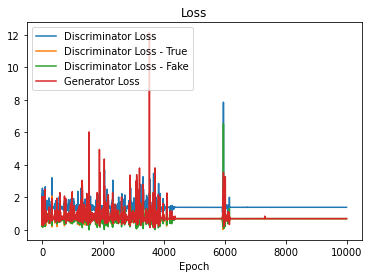

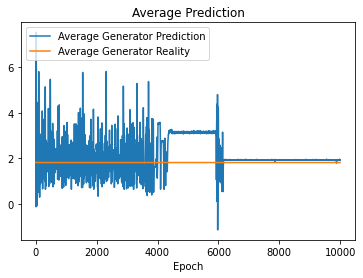

In [19]:
plotting.plot_training_curve(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)
plotting.plot_ypred_with_locations(X_valid, y_valid, ypred_regcgan_valid, ypred_gp_valid,
                          fig_dir=fig_dir, prefix="RegCGAN_GP", save_fig=exp_config.run.save_fig,
                          alpha=0.5, elevation=30, azimuth=60)


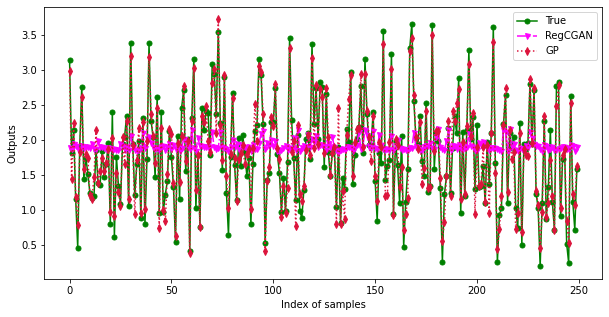

In [21]:
plotting.plot_ypred(y_valid, ypred_regcgan_valid, ypred_gp_valid,
                          fig_dir=fig_dir, prefix="regcgan_gp", save_fig=exp_config.run.save_fig)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

regcgan_mae_list = []
regcgan_mse_list = []

gp_mae_list = []
gp_mse_list =[]

n_eval_runs = 10
for i in range(n_eval_runs):

    ypred_regcgan = regcgan.predict(X_CVT)
    regcgan_mae_list.append(mean_absolute_error(y_valid, ypred_regcgan))
    regcgan_mse_list.append(mean_squared_error(y_valid, ypred_regcgan))

    yped_gp = np.random.normal(ypred_gp_valid, np.sqrt(cov_valid))
    gp_mae_list.append(mean_absolute_error(y_valid, yped_gp))
    gp_mse_list.append(mean_squared_error(y_valid, yped_gp))


In [ ]:
regcgan_mae_mean, regcgan_mae_std = np.mean(np.asarray(regcgan_mae_list)), np.std(np.asarray(regcgan_mae_list))
regcgan_mse_mean, regcgan_mse_std = np.mean(np.asarray(regcgan_mse_list)), np.std(np.asarray(regcgan_mse_list))

print(f"MAE for RegCGAN: {regcgan_mae_mean:.3f} +- {regcgan_mae_std:.5f}")
print(f"MSE for RegCGAN: {regcgan_mse_mean:.3f} +- {regcgan_mse_std:.5f}")

gp_mae_mean, gp_mae_std = np.mean(np.asarray(gp_mae_list)), np.std(np.asarray(gp_mae_list))
gp_mse_mean, gp_mse_std = np.mean(np.asarray(gp_mse_list)), np.std(np.asarray(gp_mse_list))
print(f"MAE for GP: {gp_mae_mean:.3f} +- {gp_mae_std:.5f}")
print(f"MSE for GP: {gp_mse_mean:.3f} +- {gp_mse_std:.5f}")

In [ ]:
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.gaussian_NLPD(y_valid, np.random.normal(ypred_gp_valid, np.sqrt(cov_valid)), cov_valid))
gp_nlpd_mean = np.mean(nlpd_list)
gp_nlpd_std = np.std(nlpd_list)
print(f"NLPD for GP: {gp_nlpd_mean:.3f} +- {gp_nlpd_std:.5f}")

In [ ]:
# nlpd_list = []
# for i in range(n_eval_runs):
#     ypred_single_cgan_cvt = regcgan.predict(X_CVT)
#     cov = np.ones(len(ypred_single_cgan_cvt))* np.mean((y - ypred_single_cgan_cvt)**2)
#     nlpd_list.append(metrics.gaussian_NLPD(y, ypred_single_cgan_cvt, cov))
# single_cgan_nlpd_mean = np.mean(nlpd_list)
# single_cgan_nlpd_std = np.std(nlpd_list)
# print(f"Single CGAN Validation NLPD: {single_cgan_nlpd_mean:.3f} +- {single_cgan_nlpd_std:.5f}")

In [ ]:
# _, w, _ = metrics.Parzen(regcgan, X_train, y_train)
# nlpd_list = []
# for i in range(n_eval_runs):
#     nlpd_list.append(metrics.Parzen_test(regcgan, X_CVT, y, w, exp_config.training.n_samples))
# mean_cgan_nlpd_mean = np.mean(nlpd_list)
# mean_cgan_nlpd_std = np.std(nlpd_list)
# print(f"Mean CGAN Validation NLPD: {mean_cgan_nlpd_mean:.3f} +- {mean_cgan_nlpd_std:.5f}")

In [ ]:
regcgan_nlpd_train, w, lls = metrics.Parzen(regcgan, X_train, y_train)
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.Parzen_test(regcgan, X_valid, y_valid, w, exp_config.training.n_sampling))
regcgan_nlpd_mean = np.mean(nlpd_list)
regcgan_nlpd_std = np.std(nlpd_list)
print(f"NLPD for RegCGAN:  {regcgan_nlpd_mean:.3f} +- {regcgan_nlpd_std:.5f}")

In [ ]:
if exp_config.run.save_fig:

    try:
        file = open(f"{fig_dir}/metrics_on_validation_samples.txt","w")
    except FileExistsError:
        print(f" {fig_dir} was failed to create.")

    file.write(f"=== MAE ===\n")
    file.write(f"MAE for GP: {gp_mae_mean} +- {gp_mae_std}\n")
    file.write(f"MAE for RegCGAN: {regcgan_mae_mean} +- {regcgan_mae_std}\n")
    file.write(f"=== MSE ===\n")
    file.write(f"MSE for GP : {gp_mse_mean} +- {gp_mse_std}\n")
    file.write(f"MSE for CGAN: {regcgan_mse_mean} +- {regcgan_mse_std}\n")
    file.write(f"=== NLPD ===\n")
    file.write(f"NLPD for GP: {gp_nlpd_mean} +- {gp_nlpd_std}\n")
    file.write(f"NLPD for RegCGAN: {regcgan_nlpd_mean} +- {regcgan_nlpd_std}\n")
    file.close()
